In [1]:
%load_ext autoreload
%autoreload 2
    
from new_epe_code import *

2025-09-16 20:17:05.962912: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-16 20:17:05.962945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-16 20:17:05.964031: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-16 20:17:07.852855: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import numpy as np

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import torch

import numpy as np
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

#device = 'cpu'


Device: cuda


In [3]:
# specify different Pk combinations for sigma8 measurement

folder = "./" #"/data80/mattho/for_people/for_lucas/"

In [18]:
cosmonames = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$']

hodnames = [r'$\alpha$', r'$\log M_0$', r'$\log M_1$',
            r'$\log M_{\min}$', r'$\sigma_{\log M}$']


n_params = 5 # COSMO ONLY

x_train = np.load(folder + "x_train.npy")
theta_train = np.load(folder + "theta_train.npy")[:, :n_params]

x_test = np.load(folder + "x_test.npy")
theta_test = np.load(folder + "theta_test.npy")[:, :n_params]

x_val = np.load(folder + "x_val.npy")
theta_val = np.load(folder + "theta_val.npy")[:, :n_params]


# STANDARDISE EVERYTHING
S1_cls = x_train.mean(0)
S2_cls = (x_train**2).mean(0)

mean_cl = S1_cls
std_cl = np.sqrt(S2_cls - mean_cl**2)
#cut_idx = 22

pk_cut = 63 * 3 # 174

def slice_cls_single(data, cut=pk_cut):
    data = (data - mean_cl) / std_cl
    return data[:cut]


def get_bk(data, cut=pk_cut):
    data = (data - mean_cl) / std_cl
    return data[cut:-10]




x_train.shape, theta_train.shape, x_test.shape, theta_test.shape, x_val.shape, theta_val.shape

((8000, 1438), (8000, 5), (1000, 1438), (1000, 5), (1000, 1438), (1000, 5))

In [19]:
x_train[0].shape

(1438,)

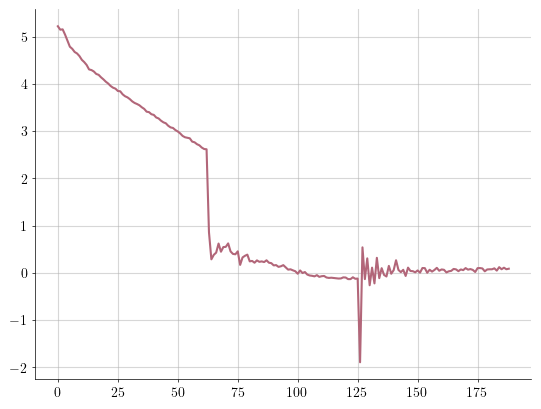

In [20]:
plt.plot((x_train[100][:pk_cut]))

In [21]:
get_bk(x_val).min()

-22.15779738561306

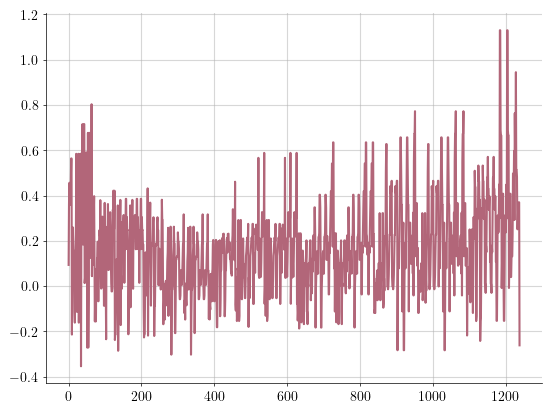

In [22]:
plt.plot(get_bk(x_train[0]))

In [23]:
theta_train.mean(0)

array([0.29774412, 0.05005614, 0.7002485 , 0.9980635 , 0.8017885 ])

# test EPE MDN embedding code for full summary vector
- compare to built-in FCN for NPE
- do hybrid thing with Pk vs Bk

In [24]:
theta_fid = theta_train.mean(0)

In [25]:
class resMLP(nn.Module):
    """
    fully connected network
    """ 
    features: Sequence[int]
    act: Callable = nn.relu
    activate_final: bool = False

    @nn.compact
    def __call__(self, x):
        x = self.act(nn.Dense(self.features[0])(x))
        for feat in self.features[1:-1]:
            x1 = self.act(nn.Dense(feat)(x))
            x += x1
        x = nn.Dense(self.features[-1])(x)

        if self.activate_final:
            x = self.act(x)

        return x

class finalCompress(EPEModel, nn.Module):
    n_summaries: int
    n_params: int = 3
    n_components: int = 4
    # mlp: nn.Module
    

    def setup(self):
        self.mdn = MDN(
                        hidden_channels=[128],
                        n_components=self.n_components,
                        n_dimension=self.n_params,
                        act=nn.swish,
                        theta_star=jnp.array(theta_train.mean(0))
        )
        
        self.mlp = resMLP(features=[500, 500, 500, self.n_summaries],
                      act=smooth_leaky) # swish, smooth_leaky, gelu, 
        self.norm = nn.LayerNorm()         

    def get_embed(self, x):
        x = slice_cls_single(x)
        x = self.mlp(x)
        return self.norm(x)

    def log_prob(self, x, theta):
        x = self.get_embed(x)
        #x = self.norm(x)
        return self.mdn(x, theta) 

    #@nn.compact
    
    def __call__(self, x, theta):
        theta -= theta_fid
        return self.log_prob(x, theta)

In [26]:
from sklearn.preprocessing import StandardScaler
key = jr.PRNGKey(4)

modelfinal = finalCompress(n_summaries=7, n_params=n_params, n_components=7)
wfinal = modelfinal.init(key, x_train[0], jnp.ones(n_params,), method=modelfinal.log_prob)


# scaler = StandardScaler()
# summs_train = scaler.fit_transform(x_train)
# summs_val = scaler.transform(x_val)



In [33]:
key = jax.random.PRNGKey(999)

def noise_simulator(key, data):
    """add in gaussian noise to the Cls for training"""
    return data + jr.normal(key, shape=(x_train.shape[-1])) * 1e-4 * std_cl


def run_final_embedding_loop(model, 
                             key,
                             train_data, # tuple of (d ,theta)
                             test_data,
                             epochs=1000,
                             batch_size=64,
                             learning_rate=5e-6,
                            n_params=5,
                            w=None):

    
    data_train, theta_train = train_data
    data_test, theta_test =  test_data

    data_single_shape = data_train[0].shape
    
    n_train = data_train.shape[0]
    
    remainder = batch_size * (data_train.shape[0] // batch_size)
    
    data_ = data_train[:remainder].reshape((-1, batch_size,) + data_single_shape)
    theta_ = theta_train[:remainder].reshape(-1, batch_size, n_params)
    
    # reshape the test data into batches
    remainder = batch_size * (data_test.shape[0] // batch_size)

    data_test = data_test[:remainder].reshape((-1, batch_size,) + data_single_shape)
    theta_test = theta_test[:remainder].reshape(-1, batch_size, n_params)

    @jax.jit
    def logprob_loss(w, x_batched, theta_batched):
    
        def fn(x, theta):
           logp = model.apply(w, x, theta)
           return logp
    
        logp_batched = jax.vmap(fn)(x_batched, theta_batched)
        return -jnp.mean(logp_batched)

    
    # init model again
    if w is None:
        w = model.init(key, data_train[0], jnp.ones(n_params,))
    
    # # Clip gradients at max value, and evt. apply weight decay
    transf = [optax.clip(2.0)]
    transf.append(optax.add_decayed_weights(1e-4))
    tx = optax.chain(
        *transf,
        optax.adam(learning_rate=learning_rate)
    )
    opt_state = tx.init(w)
    loss_grad_fn = jax.value_and_grad(logprob_loss)

    
    # this is a hack to make the for-loop training much faster in jax
    def body_fun(i, inputs):
        w,loss_val, opt_state, _data, _theta, key = inputs
        x_samples = _data[i]
        y_samples = _theta[i]
    
        # apply noise simulator
        keys = jr.split(key, x_samples.shape[0])
        #x_samples = jax.vmap(noise_simulator)(keys, x_samples)
    
    
        loss_val, grads = loss_grad_fn(w, x_samples, y_samples)
        updates, opt_state = tx.update(grads, opt_state, w)
        w = optax.apply_updates(w, updates)
    
        return w, loss_val, opt_state, _data, _theta, key
    
    
    def val_body_fun(i, inputs):
        w,loss_val, _data, _theta, key = inputs
        x_samples = _data[i]
        y_samples = _theta[i]
    
        # apply noise simulator
        keys = jr.split(key, x_samples.shape[0])
        #x_samples = jax.vmap(noise_simulator)(keys, x_samples)
    
        loss_val, grads = loss_grad_fn(w, x_samples, y_samples)
    
        return w, loss_val, _data, _theta, key
    

    
    losses = jnp.zeros(epochs)
    val_losses = jnp.zeros(epochs)
    loss_val = 0.
    val_loss_value = 0.
    best_val_loss = jnp.inf
    lower = 0
    upper = n_train // batch_size

    best_w = w
    
    pbar = tqdm(range(epochs), leave=True, position=0)
    counter = 0
    
    for j in pbar:
          key,rng = jax.random.split(key)
    
          # shuffle data every epoch
          randidx = jr.permutation(key, jnp.arange(theta_.reshape(-1, n_params).shape[0]), independent=True)
          _data = data_.reshape((-1,) + data_single_shape)[randidx].reshape((-1, batch_size,) + data_single_shape)
          _theta = theta_.reshape(-1, n_params)[randidx].reshape(-1, batch_size, n_params)
    
          #print(_data.shape)
    
          inits = (w, loss_val, opt_state, _data, _theta, key)
          w, loss_val, opt_state, _data, _theta, key = jax.lax.fori_loop(lower, upper, body_fun, inits)
          losses = losses.at[j].set(loss_val)
    
    
          # do validation set
          key,rng = jr.split(key)
          inits = (w, loss_val, data_test, theta_test, key)
          w, val_loss_value, data_test, theta_test, key = jax.lax.fori_loop(0, data_test.shape[0], val_body_fun, inits)
          val_losses = val_losses.at[j].set(val_loss_value)
    
          #val_losses.append(val_loss)
          pbar.set_description('epoch %d loss: %.5f  val loss: %.5f'%(j, loss_val, val_loss_value))


          if val_loss_value < best_val_loss:
              best_val_loss = val_loss_value
              best_w = w
    
    
          counter += 1

    return best_w, (losses, val_losses)


In [34]:
w, final_losses = run_final_embedding_loop(modelfinal, key, (x_train, theta_train),
                                           (x_val, theta_val), epochs=250, n_params=n_params) # 450

epoch 249 loss: -8.85425  val loss: -7.21347: 100%|██████████| 250/250 [00:30<00:00,  8.16it/s]


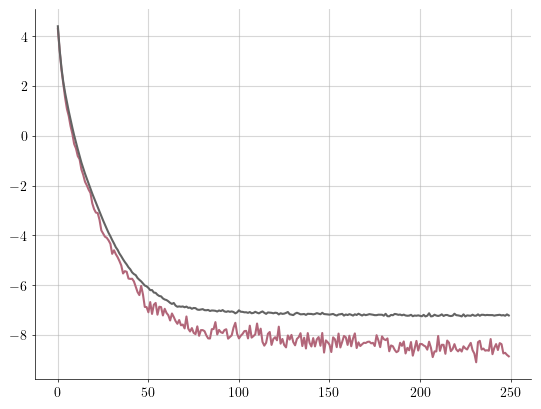

In [35]:
plt.plot(final_losses[0])
plt.plot(final_losses[1])
plt.show()

In [36]:
def get_summs_and_norm(summaries):
    appl = lambda d: modelfinal.apply(w, d, method=modelfinal.get_embed)
    summaries = jax.vmap(appl)(summaries)
    # summaries = (summaries - summaries.mean(0)) / summaries.std(0)
    return np.array(summaries)

In [37]:
#appl = lambda d: modelfinal.apply(w, d, method=modelfinal.get_embed)
    
summz_val = get_summs_and_norm(x_val)
summz_train = get_summs_and_norm(x_train)
summz_test = get_summs_and_norm(x_test)

summz_train.shape

(8000, 7)

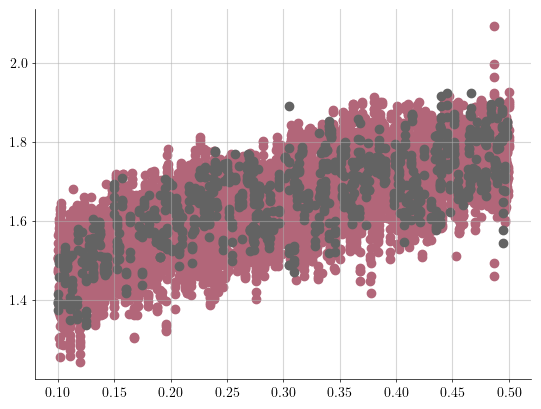

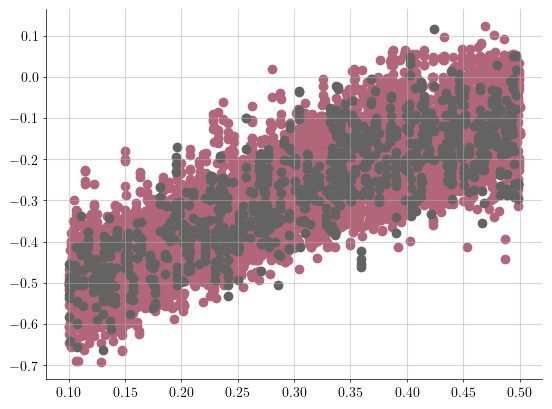

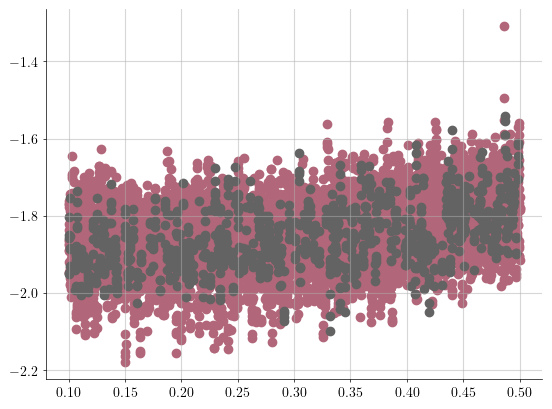

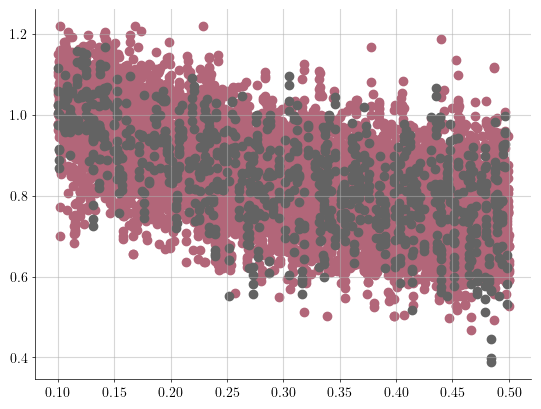

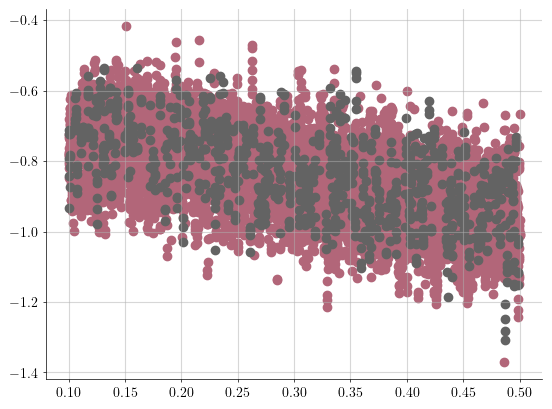

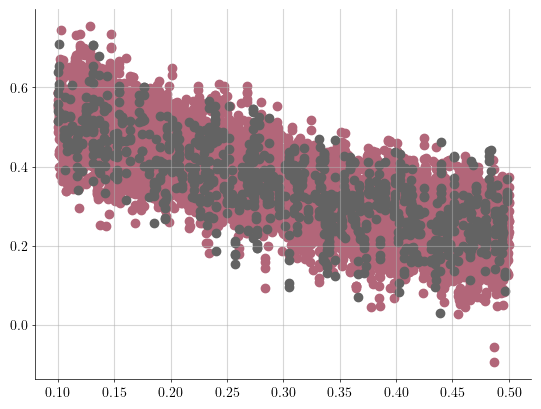

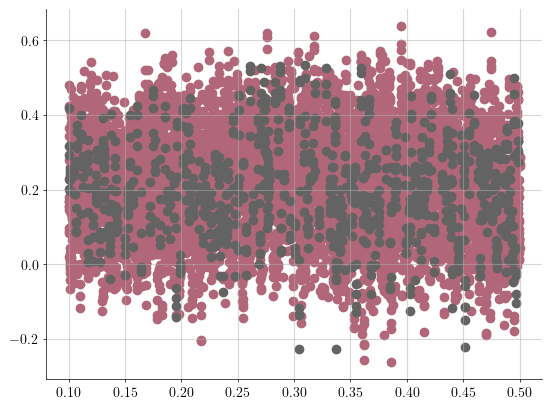

In [38]:
for i in range(summz_val.shape[1]):
    plt.scatter(theta_train[:, 0], summz_train[:, i])
    plt.scatter(theta_val[:, 0], summz_val[:, i])
    plt.show()

## now do the hybrid thing


In [39]:
pk_net = lambda d:  modelfinal.apply(w, d, method=modelfinal.get_embed) 


In [40]:

class hybridNet(EPEModel, nn.Module):
    n_summaries: int
    n_params: int = 3
    n_components: int = 4
    # mlp: nn.Module
    

    def setup(self):
        self.mdn = MDN(
                        hidden_channels=[128],
                        n_components=self.n_components,
                        n_dimension=self.n_params,
                        act=nn.relu,
                        theta_star=jnp.array(theta_train.mean(0))
        )
        
        self.mlp = resMLP(features=[500, 500, 500, self.n_summaries],
                      act=smooth_leaky) # swish, smooth_leaky, gelu, 
        self.norm = nn.LayerNorm()         

    def get_embed(self, x):
        # get pk summaries
        pk = pk_net(x)

        # get Bk summaries
        x = get_bk(x)
        x = self.mlp(x)
        x = jnp.concatenate([pk, x], -1)
        return self.norm(x)

    def log_prob(self, x, theta):
        x = self.get_embed(x)
        return self.mdn(x, theta) 

    #@nn.compact
    
    def __call__(self, x, theta):
        return self.log_prob(x, theta)

In [41]:
mean_cl.shape, std_cl.shape, x_train[0].shape

((1438,), (1438,), (1438,))

In [42]:
from sklearn.preprocessing import StandardScaler
key = jr.PRNGKey(4)

modelhybrid = hybridNet(n_summaries=5, n_params=n_params, n_components=7)
wfinal = modelhybrid.init(key, x_train[0], jnp.ones(n_params,), method=modelhybrid.log_prob)

In [43]:
modelhybrid.apply(wfinal, x_train[0], method=modelhybrid.get_embed)

Array([ 1.7147546 , -0.5313824 , -2.3008537 ,  1.1468399 , -0.92153835,
        0.53031576,  0.28952038,  0.13458188,  0.5172315 , -0.09956057,
        0.28113282, -0.7610419 ], dtype=float32)

In [44]:
x_train.min(), x_train.max()

(-6.59176003468815, 28.38075065612793)

In [45]:
import jax
jax.config.update("jax_debug_nans", True)

In [46]:
w_hybrid, final_losses = run_final_embedding_loop(modelhybrid, key, (x_train, theta_train),
                                           (x_val, theta_val), epochs=250, n_params=n_params)

epoch 249 loss: -8.43031  val loss: -7.04281: 100%|██████████| 250/250 [00:50<00:00,  4.94it/s]


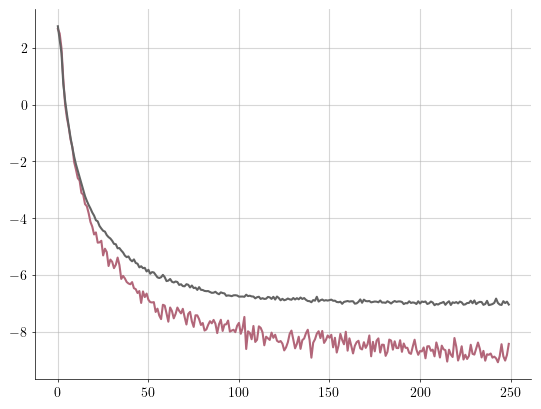

In [47]:
plt.plot(final_losses[0])
plt.plot(final_losses[1])
plt.show()

In [48]:
def get_summs_and_norm(summaries):
    appl = lambda d: modelhybrid.apply(w_hybrid, d, method=modelhybrid.get_embed)
    summaries = jax.vmap(appl)(summaries)
    # summaries = (summaries - summaries.mean(0)) / summaries.std(0)
    return np.array(summaries)

In [49]:
#appl = lambda d: modelfinal.apply(w, d, method=modelfinal.get_embed)
    
summz_val = get_summs_and_norm(x_val)
summz_train = get_summs_and_norm(x_train)
summz_test = get_summs_and_norm(x_test)

summz_train.shape

(8000, 12)

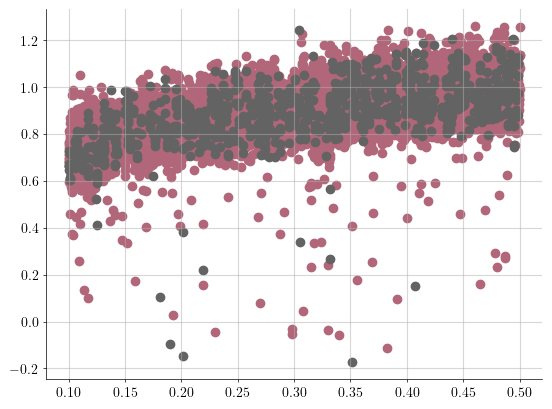

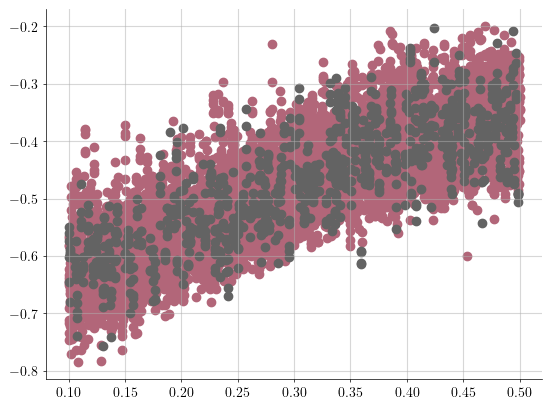

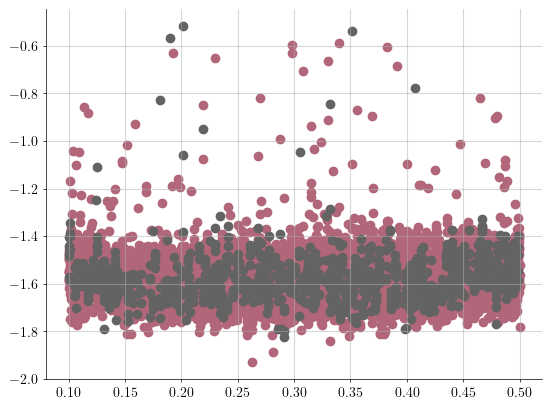

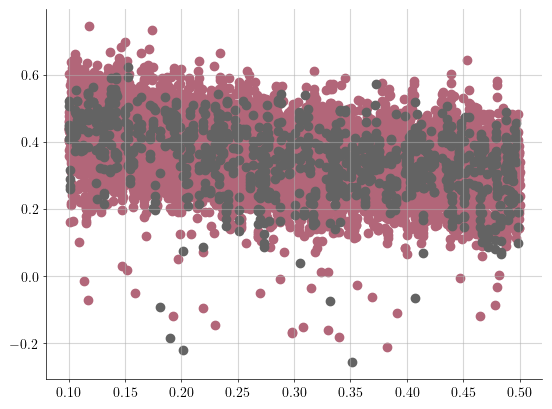

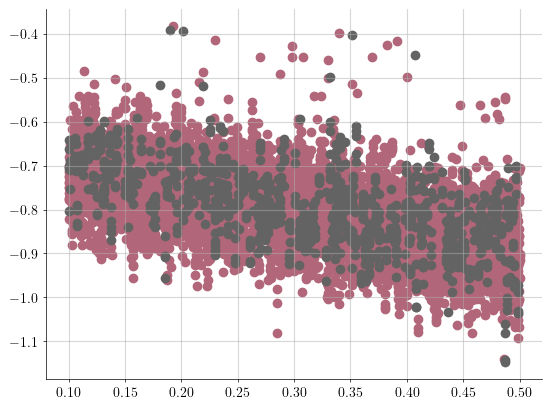

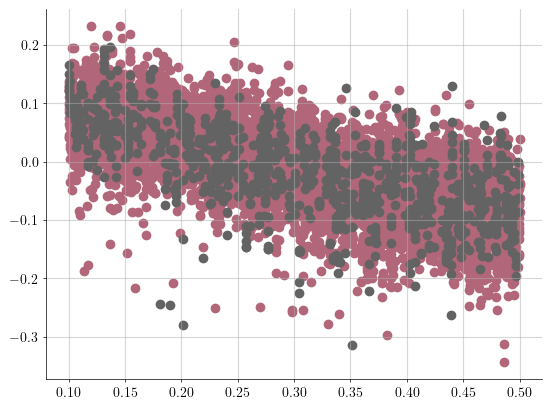

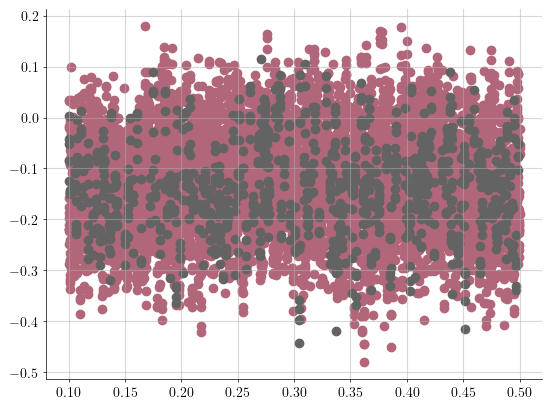

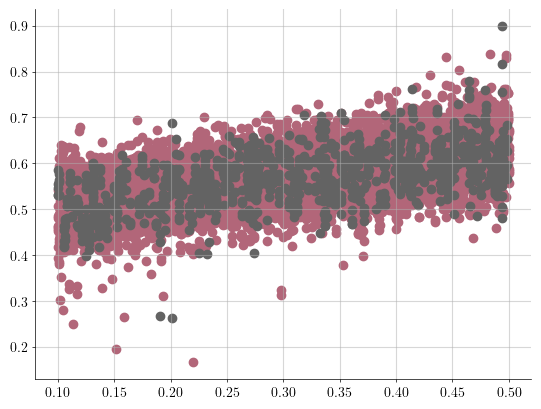

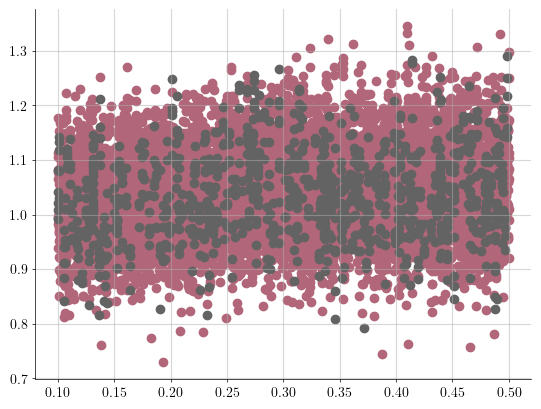

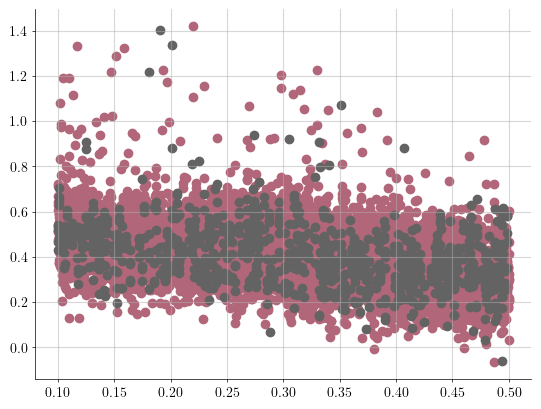

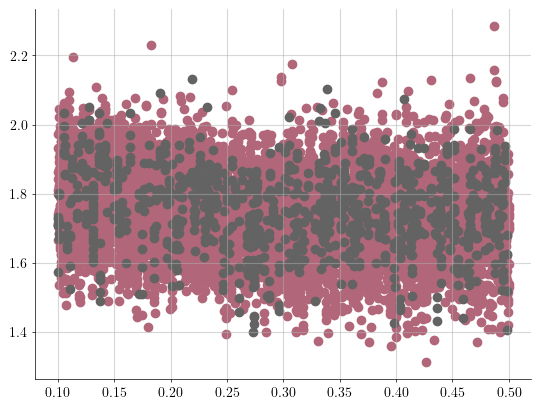

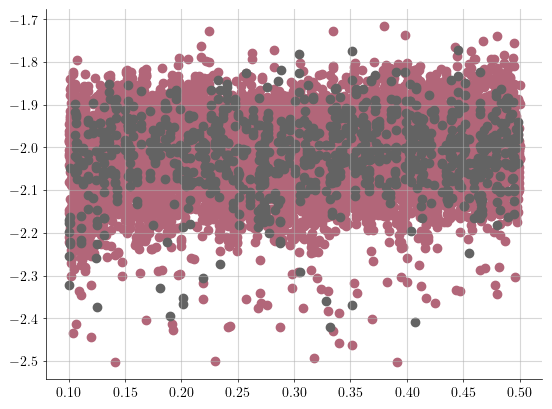

In [50]:
for i in range(summz_val.shape[1]):
    plt.scatter(theta_train[:, 0], summz_train[:, i])
    plt.scatter(theta_val[:, 0], summz_val[:, i])
    plt.show()

In [94]:
np.savez("hybrid_pk_qk_summaries_16_09",
         summs_train=summz_train,
         theta_train=theta_train,
         summs_val=summz_val,
         theta_val=theta_val,
         summs_test=summz_test,
         theta_test=theta_test)

In [73]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [105]:
summz_train.shape

(8000, 12)

In [122]:
from ili.embedding import FCN

activation = "LeakyReLU"
n_hidden = [128, 128, 6]
embedding_network = FCN(n_hidden = n_hidden, act_fn = activation)



# do cosmo first
param_idx = [0,1,2,3,4,5]

#_theta = theta_train[:, param_idx]

_theta = theta_train


# set train / val index
val_start = summz_train.shape[0]
train_idx = torch.arange(0, summz_train.shape[0])
val_idx = torch.arange(val_start, val_start + summz_val.shape[0])

loader = NumpyLoader(x=np.concatenate([summz_train, summz_val],0 ),
                             theta=np.concatenate([theta_train, theta_val], 0))

# define a prior for the scaled thetas

prior = ili.utils.Uniform(
    low=_theta.min(axis=0),
    high=_theta.max(axis=0),
    device=device)


# hiddens for NDEs: [16, 64]

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='nsf', hidden_features=100, num_transforms=12),
    ili.utils.load_nde_sbi(engine='NPE', model='nsf', hidden_features=100, num_transforms=12),
    #ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=12),
    #ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=12),
]

# define training arguments
train_args = {
    'training_batch_size': 64,
    'learning_rate': 1e-5,
    'validation_fraction': 0.25,
    'stop_after_epochs': 10
    
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    #embedding_net=embedding_network,
    train_args=train_args,
    proposal=None,
    out_dir=None,            
    train_indices=train_idx,
    val_indices=val_idx
)

posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 2.


using specified train and val indices
 Training neural network. Epochs trained: 59

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 82 60 epochs.

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 2434.654465198517 seconds to train models.


 Neural network successfully converged after 83 epochs.

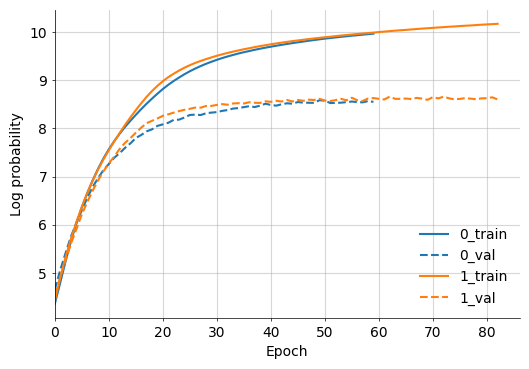

In [123]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [52]:
from ili.embedding import FCN

activation = "LeakyReLU"
n_hidden = [128, 128, 6]
embedding_network = FCN(n_hidden = n_hidden, act_fn = activation)



# do cosmo first
param_idx = [0,1,2,3,4,5]

#_theta = theta_train[:, param_idx]

_theta = theta_train


# set train / val index
val_start = summz_train.shape[0]
train_idx = torch.arange(0, summz_train.shape[0])
val_idx = torch.arange(val_start, val_start + summz_val.shape[0])

N_SUMMS = 7

loader = NumpyLoader(x=np.concatenate([summz_train[:, :N_SUMMS], summz_val[:, :N_SUMMS]],0 ),
                             theta=np.concatenate([theta_train, theta_val], 0))

# define a prior for the scaled thetas

prior = ili.utils.Uniform(
    low=_theta.min(axis=0),
    high=_theta.max(axis=0),
    device=device)


# hiddens for NDEs: [16, 64]

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='nsf', hidden_features=100, num_transforms=12),
    ili.utils.load_nde_sbi(engine='NPE', model='nsf', hidden_features=100, num_transforms=12),
    #ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=12),
    #ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=12),
]

# define training arguments
train_args = {
    'training_batch_size': 64,
    'learning_rate': 5e-5,
    'validation_fraction': 0.25,
    'stop_after_epochs': 10
    
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    #embedding_net=embedding_network,
    train_args=train_args,
    proposal=None,
    out_dir=None,            
    train_indices=train_idx,
    val_indices=val_idx
)

posterior_ensemble_pkonly, summaries_pkonly = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.


using specified train and val indices
 Training neural network. Epochs trained: 21

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 35 22 epochs.

INFO:root:It took 1007.6158266067505 seconds to train models.


 Neural network successfully converged after 36 epochs.

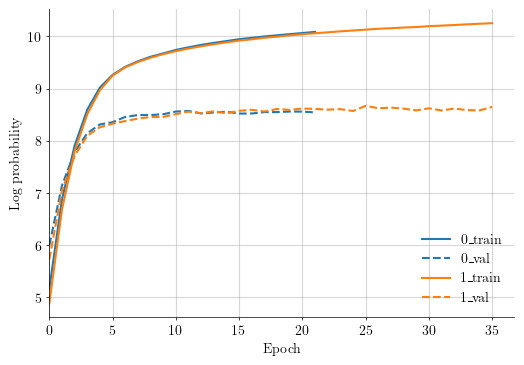

In [54]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries_pkonly):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [55]:
param_idx

[0, 1, 2, 3, 4, 5]

In [188]:
summz_test.shape, theta_test.shape

((1000, 12), (1000, 5))

In [189]:
np.argmin(theta_test - )

SyntaxError: invalid syntax (1285481903.py, line 1)

Drawing 2516 posterior samples:   0%|          | 0/2516 [00:00<?, ?it/s]

/home/makinen/venvs/epe/lib64/python3.11/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2184.)
  outputs, _ = torch.triangular_solve(


Drawing 2484 posterior samples:   0%|          | 0/2484 [00:00<?, ?it/s]

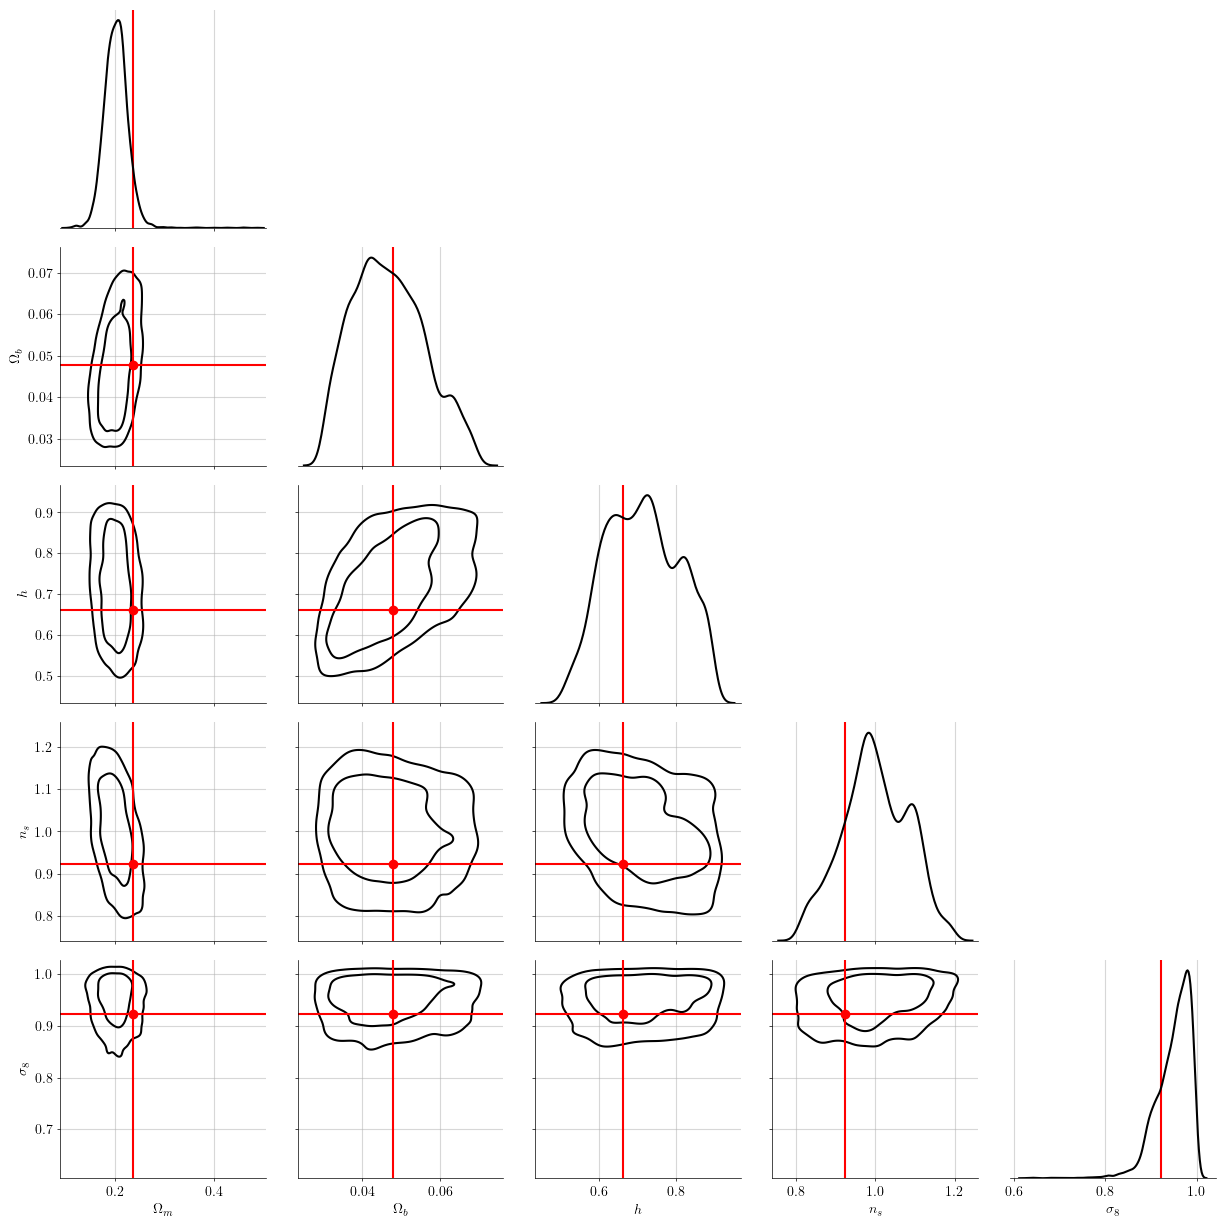

In [57]:
param_idx = np.arange(10) #[0,1,2,3,4]
#labels = [cosmonames[i] for i in param_idx]

labels = cosmonames
ind = 443

metric = PlotSinglePosterior(
    num_samples=5000, sample_method='direct',
    labels=labels
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = np.array(summz_test[ind]), theta_fid=np.array(theta_test[ind])
)
plt.show()

Drawing 2429 posterior samples:   0%|          | 0/2429 [00:00<?, ?it/s]

Drawing 2571 posterior samples:   0%|          | 0/2571 [00:00<?, ?it/s]

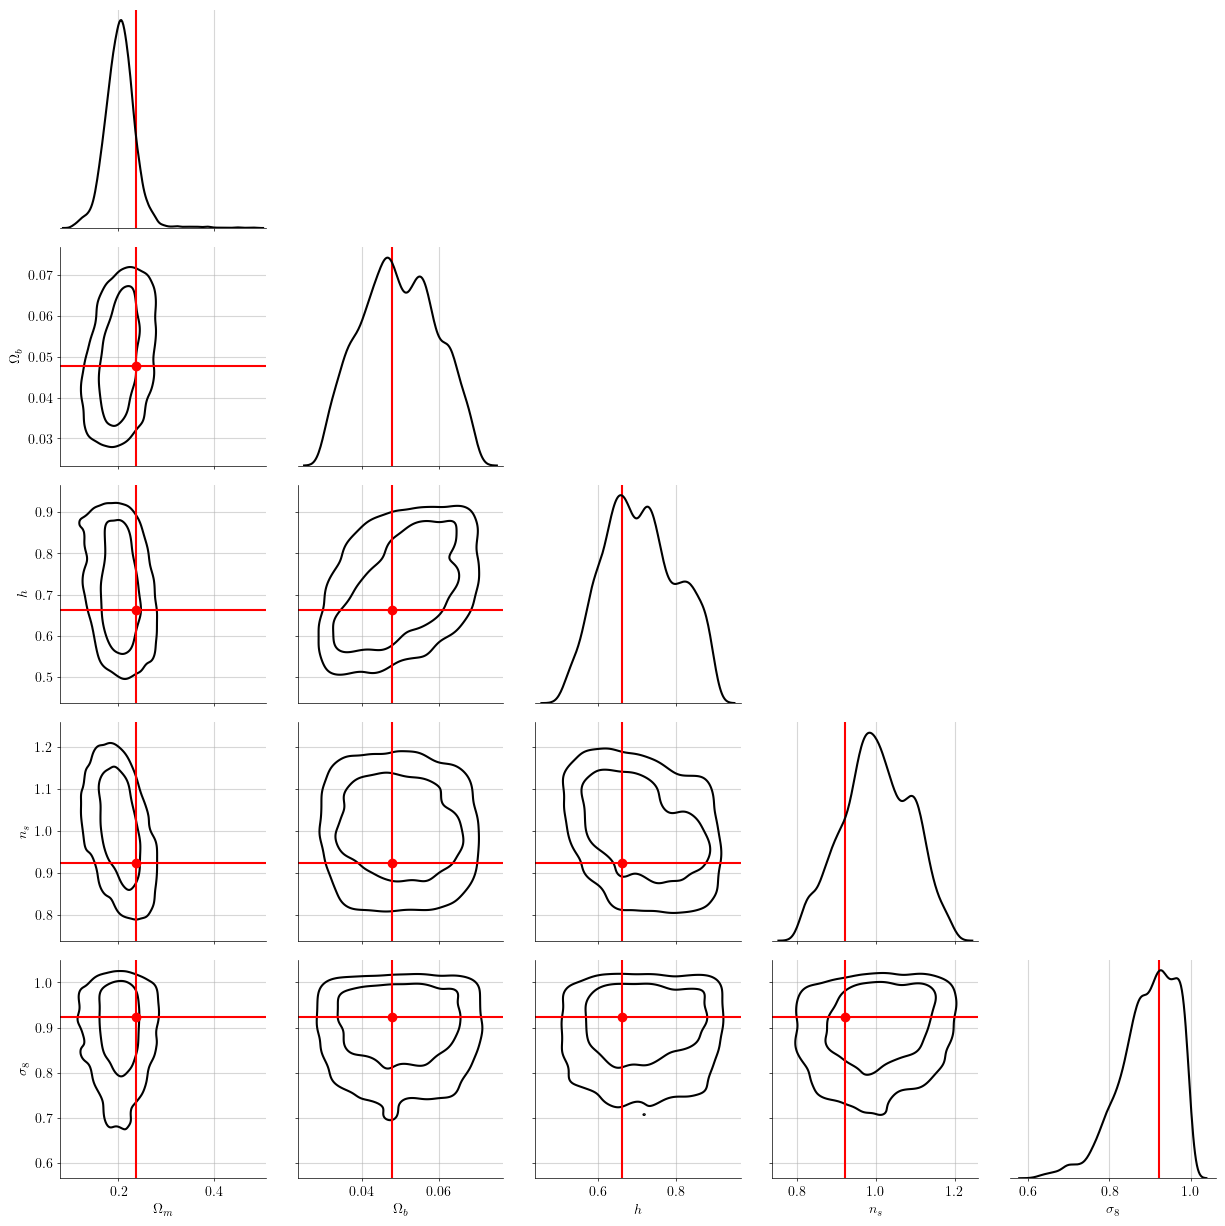

In [58]:
param_idx = np.arange(10) #[0,1,2,3,4]
#labels = [cosmonames[i] for i in param_idx]

labels = cosmonames
ind = 443

metric = PlotSinglePosterior(
    num_samples=5000, sample_method='direct',
    labels=labels
)
fig = metric(
    posterior=posterior_ensemble_pkonly,
    x_obs = np.array(summz_test[ind, :7]), theta_fid=np.array(theta_test[ind])
)
plt.show()

In [124]:
chains = posterior_ensemble.sample(sample_shape=(10000,), x=torch.tensor(summz_test[ind]).to(device))
chains_pkonly = posterior_ensemble_pkonly.sample(sample_shape=(10000,), x=torch.tensor(summz_test[ind, :7]).to(device))

Drawing 4805 posterior samples:   0%|          | 0/4805 [00:00<?, ?it/s]

Drawing 5195 posterior samples:   0%|          | 0/5195 [00:00<?, ?it/s]

Drawing 4714 posterior samples:   0%|          | 0/4714 [00:00<?, ?it/s]

Drawing 5286 posterior samples:   0%|          | 0/5286 [00:00<?, ?it/s]

In [60]:
labels

['$\\Omega_m$', '$\\Omega_b$', '$h$', '$n_s$', '$\\sigma_8$']

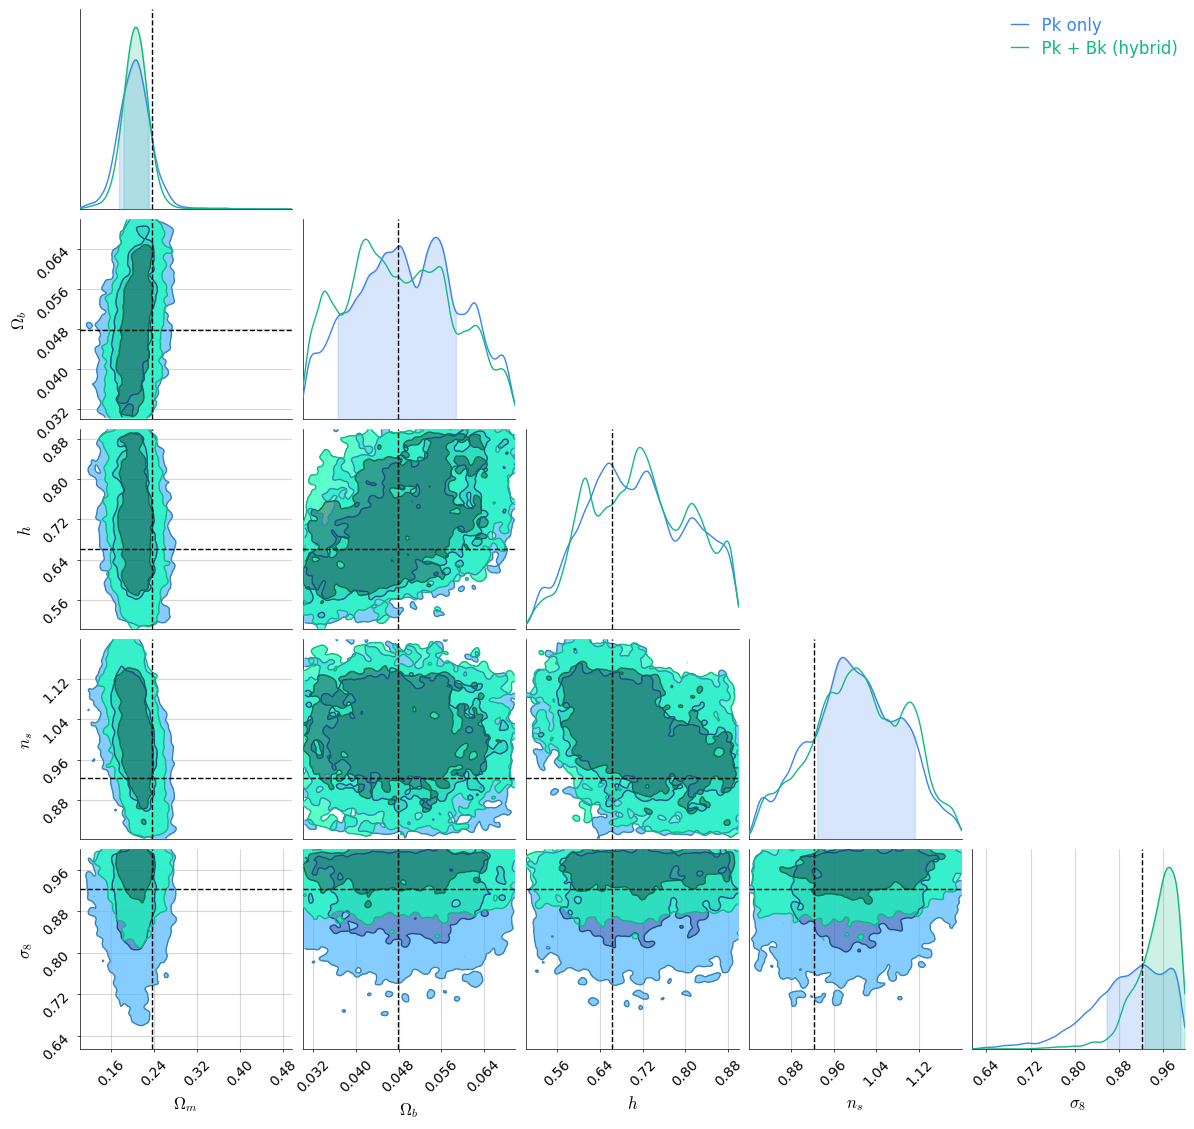

In [125]:
from chainconsumer import ChainConsumer,Chain,Truth
import pandas as pd

theta_true = theta_test[ind]

c = ChainConsumer()

thin = 1

start = 10000

df = pd.DataFrame(chains_pkonly.cpu().numpy(), columns=labels)
c.add_chain(Chain(samples=df, name="Pk only",))

df = pd.DataFrame(chains.cpu().numpy(), columns=labels)
c.add_chain(Chain(samples=df, name="Pk + Bk (hybrid)",))

c.add_truth(Truth(location={labels[0]: theta_true[0], 
                            labels[1]: theta_true[1], 
                            labels[2]: theta_true[2],
                            labels[3]: theta_true[3],
                            labels[4]: theta_true[4],
                           }))
fig = c.plotter.plot()
plt.show()

In [108]:
np.savez("hybrid_run_ind_443_16_09_nsf",
         chains=chains.cpu().numpy())

In [112]:
%pip install -U --no-deps astropy

/usr/lib64/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 76.4 MB/s eta 0:00:00
  Attempting uninstall: astropy
    Found existing installation: astropy 6.1.4
    Uninstalling astropy-6.1.4:
      Successfully uninstalled astropy-6.1.4
  You can safely remove it manually.

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [115]:
labels

['$\\Omega_m$', '$\\Omega_b$', '$h$', '$n_s$', '$\\sigma_8$']

In [126]:
# look at a bunch of predictions around a fiducial cosmology
theta_pl18 = np.array([0.3158, 0.04897, 0.67, 0.96,  0.8120])


# get a set of simulations within a small ball
eps = 0.09

# dists = ((theta_test - theta_pl18)**2).sum(-1)


dists = np.linalg.norm((theta_test - theta_pl18), axis=-1)

mask = dists < eps

print(mask.sum())


all_fid_chains = np.array([posterior_ensemble.sample(sample_shape=(10000,), x=torch.tensor(s).to(device)).cpu().numpy() for s in summz_test[mask]])


all_fid_chains_pkonly = np.array([posterior_ensemble_pkonly.sample(sample_shape=(10000,), x=torch.tensor(s).to(device)).cpu().numpy() for s in summz_test[mask][:, :7]])

10


Drawing 4766 posterior samples:   0%|          | 0/4766 [00:00<?, ?it/s]

Drawing 5234 posterior samples:   0%|          | 0/5234 [00:00<?, ?it/s]

Drawing 4720 posterior samples:   0%|          | 0/4720 [00:00<?, ?it/s]

Drawing 5280 posterior samples:   0%|          | 0/5280 [00:00<?, ?it/s]

Drawing 4931 posterior samples:   0%|          | 0/4931 [00:00<?, ?it/s]

Drawing 5069 posterior samples:   0%|          | 0/5069 [00:00<?, ?it/s]

Drawing 4807 posterior samples:   0%|          | 0/4807 [00:00<?, ?it/s]

Drawing 5193 posterior samples:   0%|          | 0/5193 [00:00<?, ?it/s]

Drawing 4776 posterior samples:   0%|          | 0/4776 [00:00<?, ?it/s]

Drawing 5224 posterior samples:   0%|          | 0/5224 [00:00<?, ?it/s]

Drawing 4833 posterior samples:   0%|          | 0/4833 [00:00<?, ?it/s]

Drawing 5167 posterior samples:   0%|          | 0/5167 [00:00<?, ?it/s]

Drawing 4835 posterior samples:   0%|          | 0/4835 [00:00<?, ?it/s]

Drawing 5165 posterior samples:   0%|          | 0/5165 [00:00<?, ?it/s]

Drawing 4824 posterior samples:   0%|          | 0/4824 [00:00<?, ?it/s]

Drawing 5176 posterior samples:   0%|          | 0/5176 [00:00<?, ?it/s]

Drawing 4833 posterior samples:   0%|          | 0/4833 [00:00<?, ?it/s]

Drawing 5167 posterior samples:   0%|          | 0/5167 [00:00<?, ?it/s]

Drawing 4873 posterior samples:   0%|          | 0/4873 [00:00<?, ?it/s]

Drawing 5127 posterior samples:   0%|          | 0/5127 [00:00<?, ?it/s]

Drawing 4730 posterior samples:   0%|          | 0/4730 [00:00<?, ?it/s]

Drawing 5270 posterior samples:   0%|          | 0/5270 [00:00<?, ?it/s]

Drawing 4810 posterior samples:   0%|          | 0/4810 [00:00<?, ?it/s]

Drawing 5190 posterior samples:   0%|          | 0/5190 [00:00<?, ?it/s]

Drawing 4729 posterior samples:   0%|          | 0/4729 [00:00<?, ?it/s]

Drawing 5271 posterior samples:   0%|          | 0/5271 [00:00<?, ?it/s]

Drawing 4696 posterior samples:   0%|          | 0/4696 [00:00<?, ?it/s]

Drawing 5304 posterior samples:   0%|          | 0/5304 [00:00<?, ?it/s]

Drawing 4750 posterior samples:   0%|          | 0/4750 [00:00<?, ?it/s]

Drawing 5250 posterior samples:   0%|          | 0/5250 [00:00<?, ?it/s]

Drawing 4743 posterior samples:   0%|          | 0/4743 [00:00<?, ?it/s]

Drawing 5257 posterior samples:   0%|          | 0/5257 [00:00<?, ?it/s]

Drawing 4707 posterior samples:   0%|          | 0/4707 [00:00<?, ?it/s]

Drawing 5293 posterior samples:   0%|          | 0/5293 [00:00<?, ?it/s]

Drawing 4713 posterior samples:   0%|          | 0/4713 [00:00<?, ?it/s]

Drawing 5287 posterior samples:   0%|          | 0/5287 [00:00<?, ?it/s]

Drawing 4781 posterior samples:   0%|          | 0/4781 [00:00<?, ?it/s]

Drawing 5219 posterior samples:   0%|          | 0/5219 [00:00<?, ?it/s]

Drawing 4757 posterior samples:   0%|          | 0/4757 [00:00<?, ?it/s]

Drawing 5243 posterior samples:   0%|          | 0/5243 [00:00<?, ?it/s]

In [127]:
np.savez("all_fid_chains_hybrid_pkcomp_16_09_2",
         chains=all_fid_chains,
         chains_pkonly=all_fid_chains_pkonly
       )

In [128]:
all_fid_chains.shape

(10, 10000, 5)

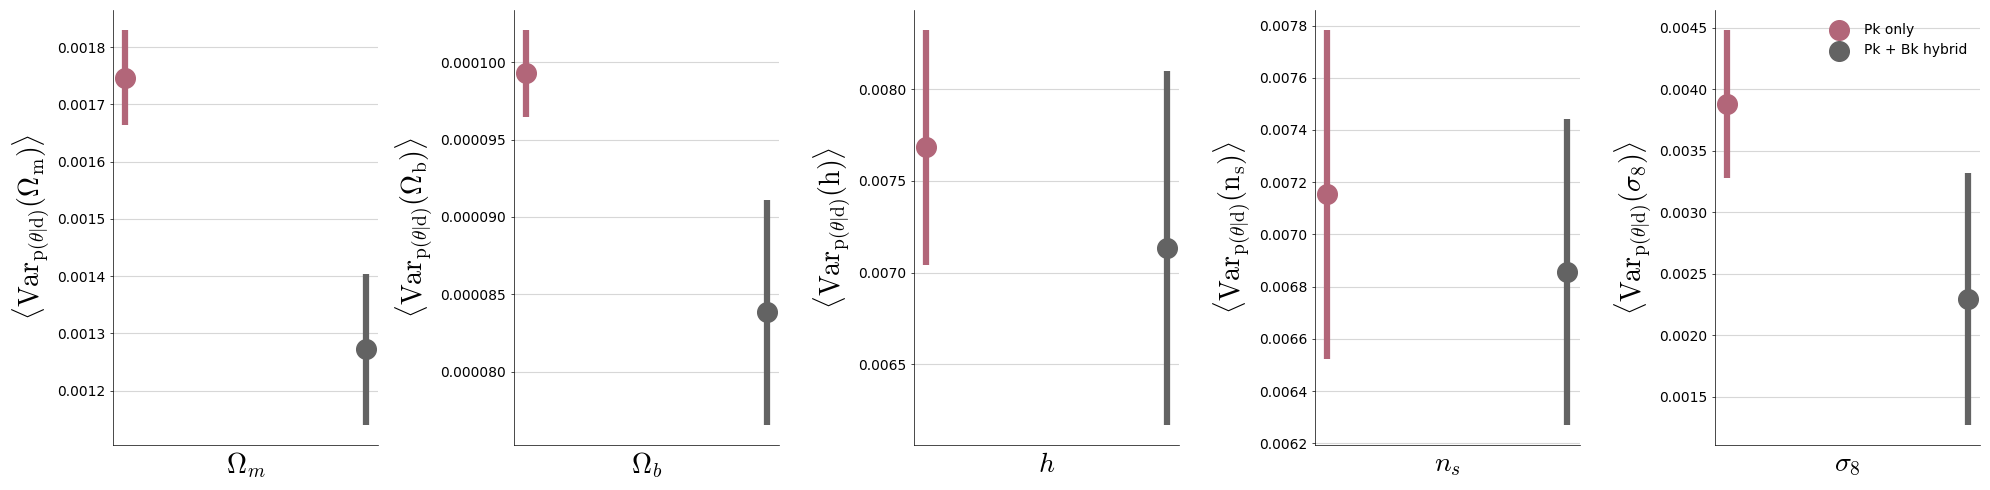

In [112]:
fig,axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
axs = axs.flatten()

newlabs = ['\Omega_m', '\Omega_b', 'h', 'n_s', '\sigma_8']



for i in range(n_params):

    axs[i].scatter(theta_test[mask][0,i], all_fid_chains_pkonly.var(1).mean(0)[i], label="Pk only", s=200,)
    axs[i].errorbar(theta_test[mask][0,i], all_fid_chains_pkonly.var(1).mean(0)[i], yerr=all_fid_chains_pkonly.var((1)).std(0)[i], lw=4.5)
    
    axs[i].scatter(theta_test[mask][0,i] + 0.05, all_fid_chains.var(1).mean(0)[i], label="Pk + Bk hybrid", s=200)
    axs[i].errorbar(theta_test[mask][0,i] + 0.05, all_fid_chains.var(1).mean(0)[i], yerr=all_fid_chains.var((1)).std(0)[i], lw=4.5)



    axs[i].set_xlabel(labels[i], fontsize=20)
    axs[i].set_xticks([])
    axs[i].set_ylabel(r"$\langle \rm{Var}_{p(\theta | d)}(%s)  \rangle$"%(newlabs[i]), fontsize=20)

plt.legend()
plt.tight_layout()

In [ ]:
fig,axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
axs = axs.flatten()

newlabs = ['\Omega_m', '\Omega_b', 'h', 'n_s', '\sigma_8']



for i in range(n_params):

    axs[i].scatter(theta_test[mask][0,i], all_fid_chains_pkonly.var(1).mean(0)[i], label="Pk only", s=200,)
    axs[i].errorbar(theta_test[mask][0,i], all_fid_chains_pkonly.var(1).mean(0)[i], yerr=all_fid_chains_pkonly.var((1)).std(0)[i], lw=4.5)
    
    axs[i].scatter(theta_test[mask][0,i] + 0.05, all_fid_chains.var(1).mean(0)[i], label="Pk + Bk hybrid", s=200)
    axs[i].errorbar(theta_test[mask][0,i] + 0.05, all_fid_chains.var(1).mean(0)[i], yerr=all_fid_chains.var((1)).std(0)[i], lw=4.5)



    axs[i].set_xlabel(labels[i], fontsize=20)
    axs[i].set_xticks([])
    axs[i].set_ylabel(r"$\langle \rm{Var}_{p(\theta | d)}(%s)  \rangle$"%(newlabs[i]), fontsize=20)

plt.legend()
plt.tight_layout()

In [111]:
print("relative improvement in posterior variance from Pk+Bk in hybrid scheme\n ---")

for i in range(5):
      print(newlabs[i] + ": %.3f"%(
      (np.abs(all_fid_chains.var(1).mean(0) - all_fid_chains_pkonly.var(1).mean(0)) / all_fid_chains_pkonly.var(1).mean(0))[i]
           ))
     

relative improvement in posterior variance from Pk+Bk in hybrid scheme
 ---
\Omega_m: 0.272
\Omega_b: 0.155
h: 0.071
n_s: 0.041
\sigma_8: 0.408


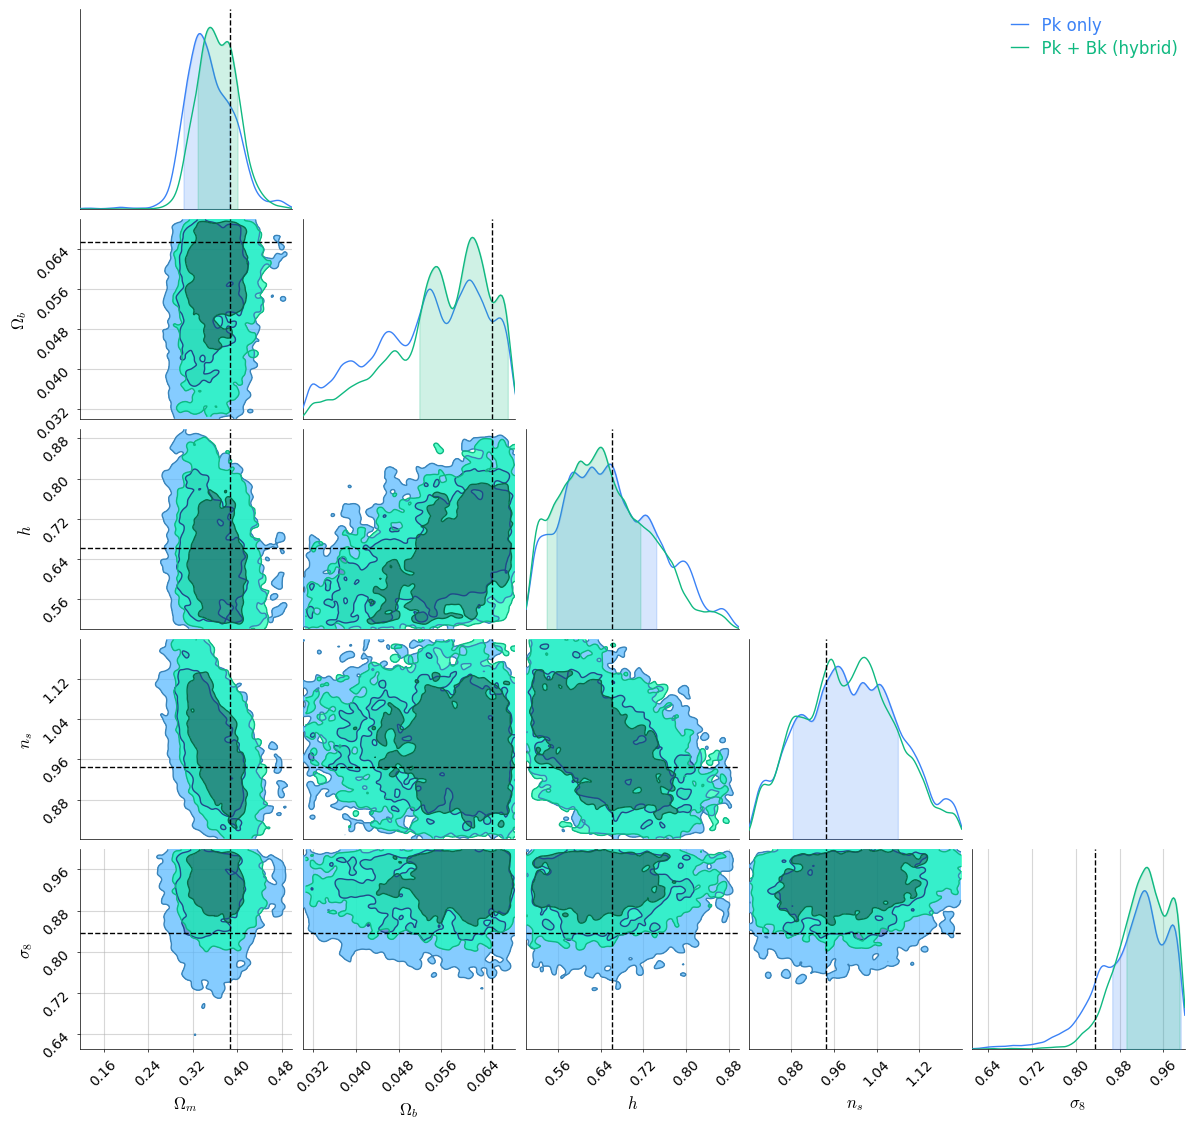

In [121]:
from chainconsumer import ChainConsumer,Chain,Truth
import pandas as pd

choice = 2

theta_true = theta_test[mask][choice]

c = ChainConsumer()

thin = 1

start = 10000

df = pd.DataFrame(all_fid_chains_pkonly[choice], columns=labels)
c.add_chain(Chain(samples=df, name="Pk only",))

df = pd.DataFrame(all_fid_chains[choice], columns=labels)
c.add_chain(Chain(samples=df, name="Pk + Bk (hybrid)",))

c.add_truth(Truth(location={labels[0]: theta_true[0], 
                            labels[1]: theta_true[1], 
                            labels[2]: theta_true[2],
                            labels[3]: theta_true[3],
                            labels[4]: theta_true[4],
                           }))
fig = c.plotter.plot()
plt.show()

In [88]:
labels

['$\\Omega_m$', '$\\Omega_b$', '$h$', '$n_s$', '$\\sigma_8$']

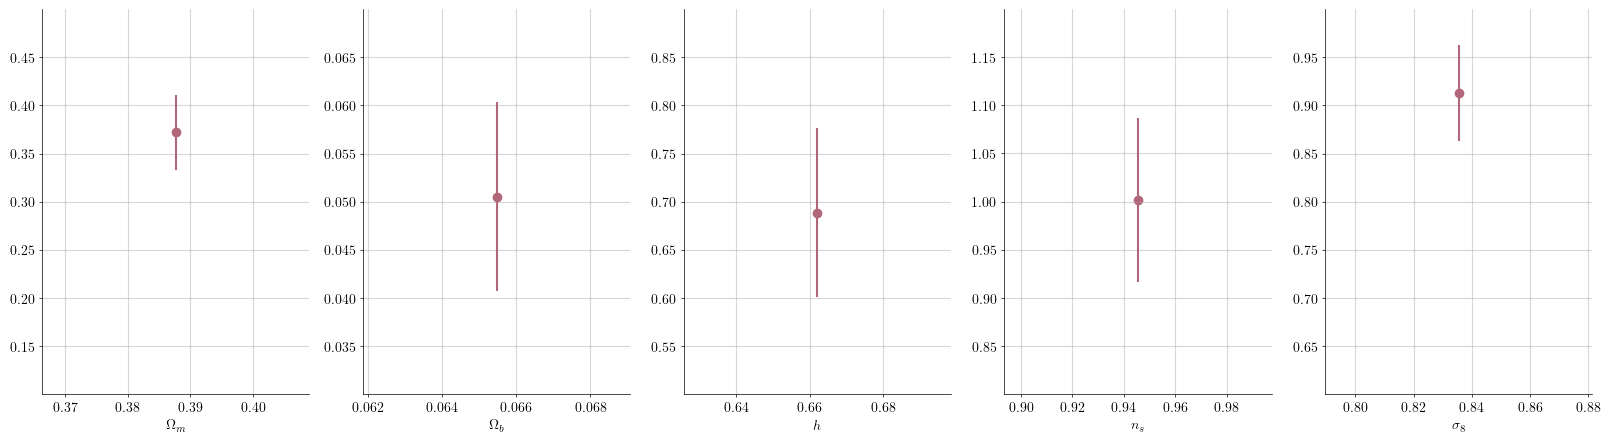

In [181]:
fig,axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
axs = axs.flatten()


for i in range(n_params):
    
    axs[i].scatter(theta_test[mask][0,i], all_fid_chains.mean(1).mean(0)[i])

    axs[i].errorbar(theta_test[mask][0,i], all_fid_chains.mean(1).mean(0)[i], yerr=all_fid_chains.std((1)).mean(0)[i])

    axs[i].set_ylim(theta_train.min(0)[i], theta_train.max(0)[i])

    axs[i].set_ylim(theta_train.min(0)[i], theta_train.max(0)[i])

    axs[i].set_xlabel(labels[i])

In [182]:
post_var

array([1.6152257e-03, 9.7138349e-05, 7.7983350e-03, 6.8355943e-03,
       3.5163087e-03], dtype=float32)

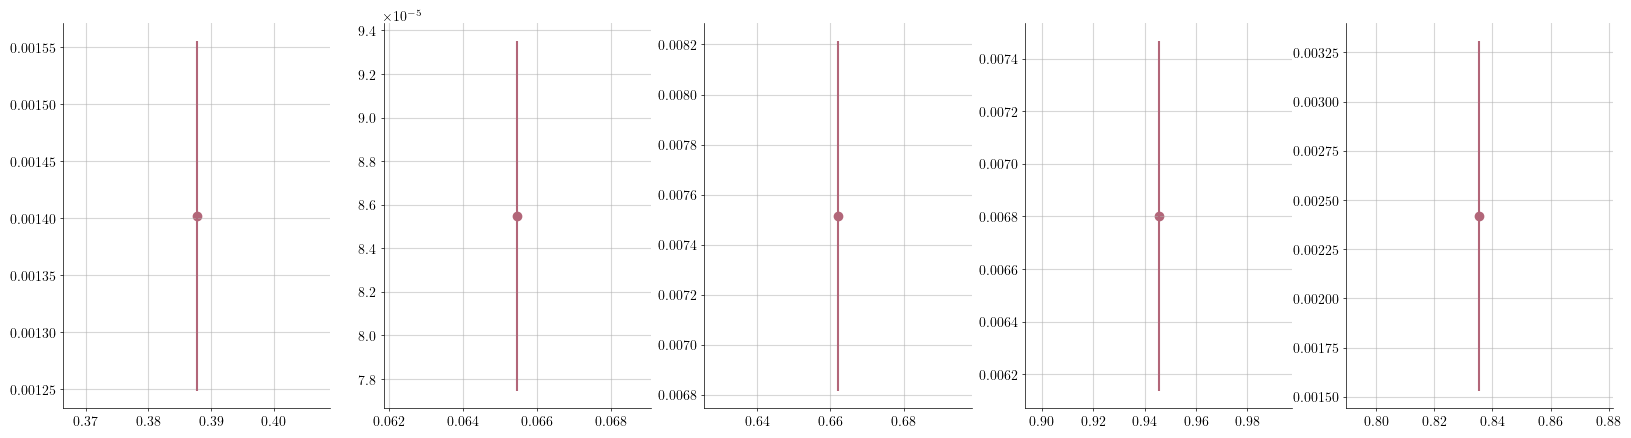

In [196]:
fig,axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
axs = axs.flatten()

post_var = all_fid_chains.var(1).mean(0)

std_post_var = all_fid_chains.var(1).std(0)

for i in range(n_params):
    
    axs[i].scatter(theta_test[mask][0,i], post_var[i])
    
    axs[i].errorbar(theta_test[mask][0,i], post_var[i], yerr=std_post_var[i])

    # axs[i].set_ylim(theta_train.min(0)[i], theta_train.max(0)[i])

    # axs[i].set_ylim(theta_train.min(0)[i], theta_train.max(0)[i])

100%|██████████| 100/100 [00:05<00:00, 17.80it/s]


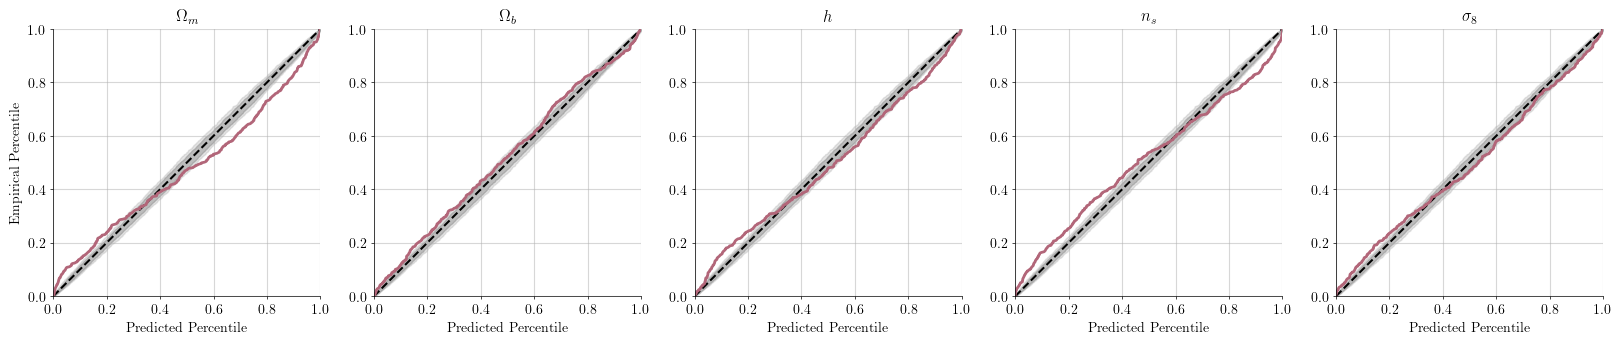

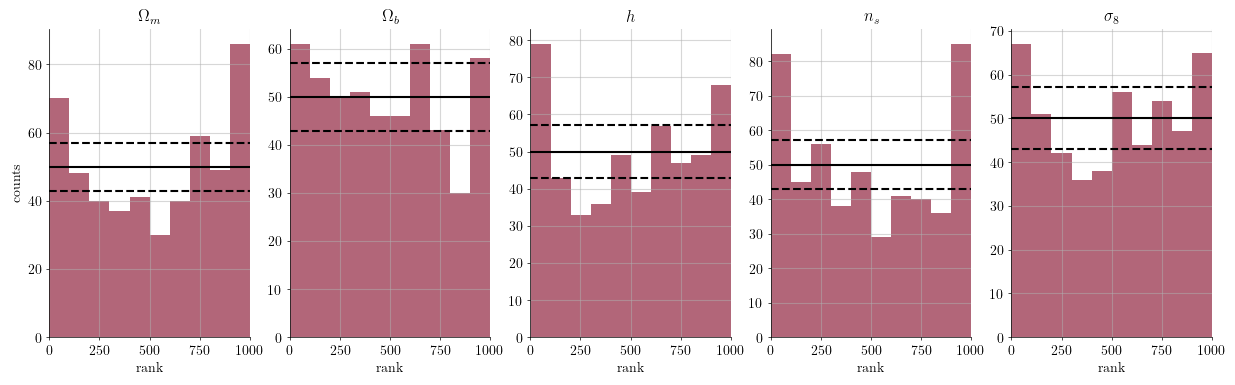

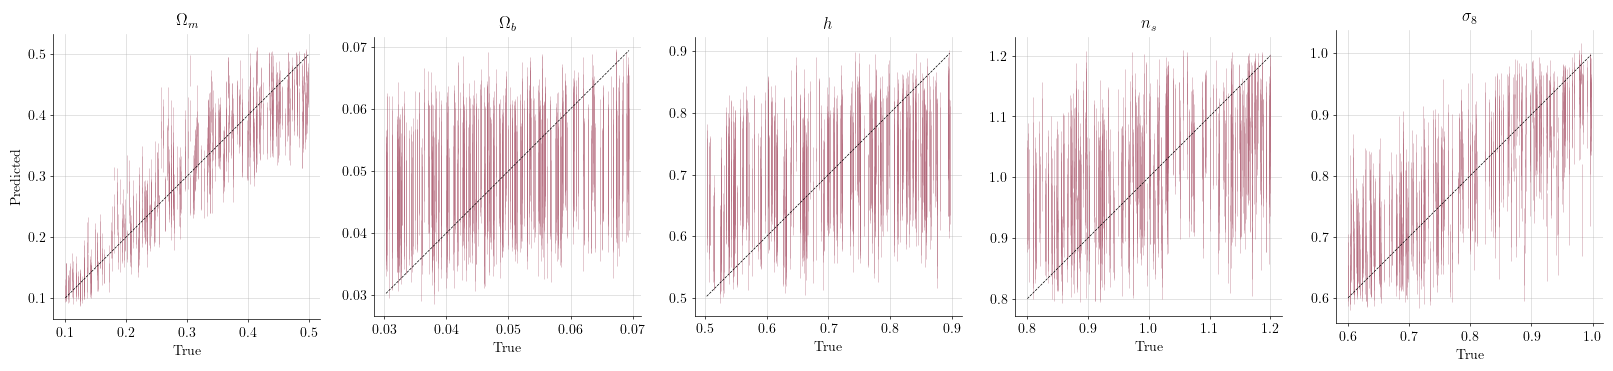

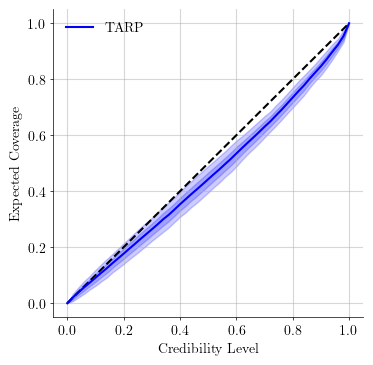

In [106]:
# FOR hybrid

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct',
    labels=labels,
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
) 

skip = 2

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=summz_val[::skip], theta=theta_val[::skip]
)
plt.show()

100%|██████████| 100/100 [00:05<00:00, 17.29it/s]


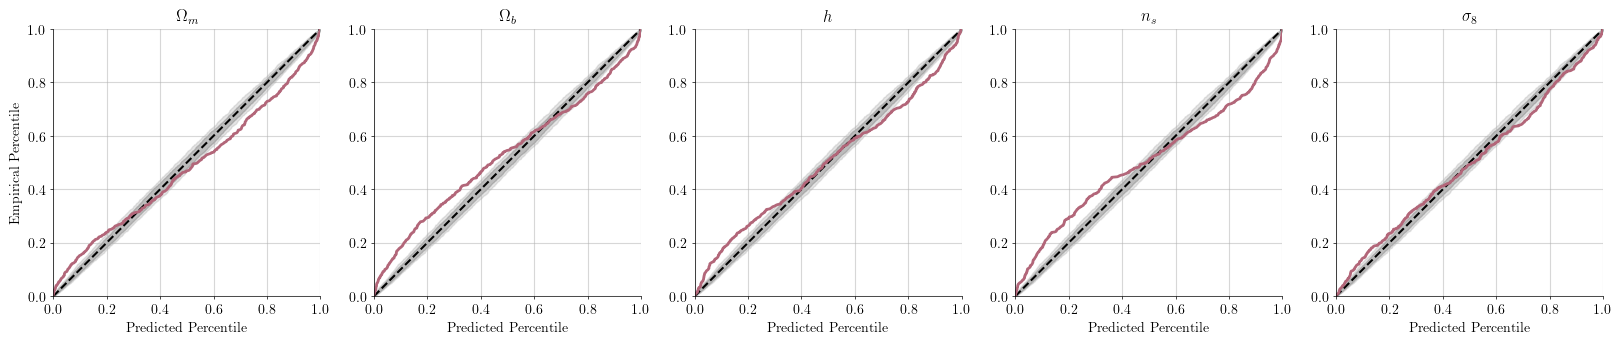

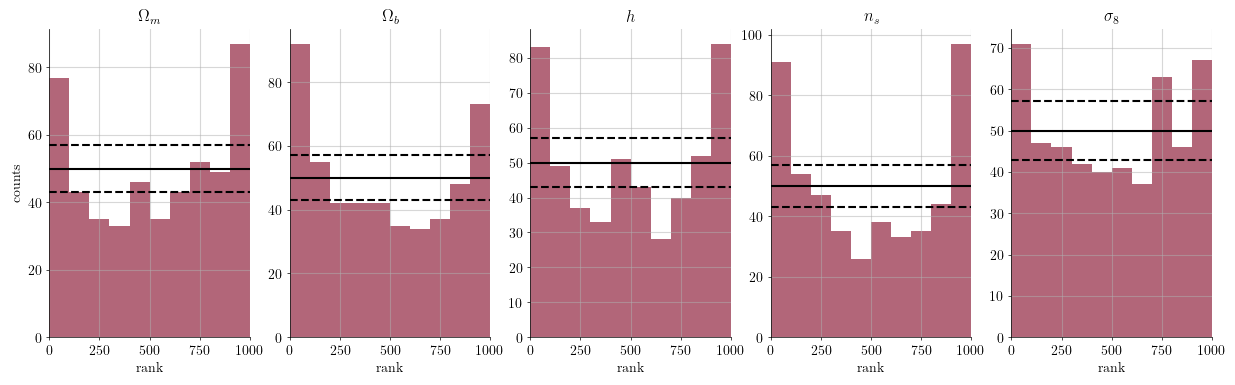

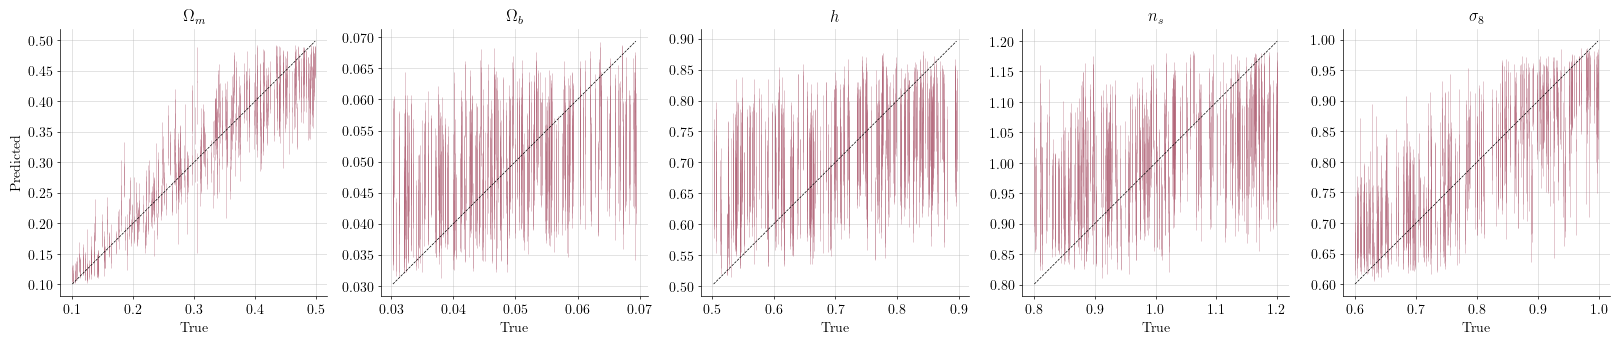

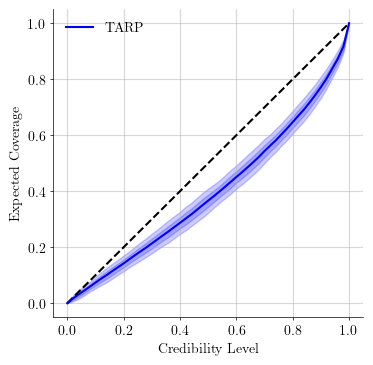

In [63]:
# FOR hybrid

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct',
    labels=labels,
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
) 

skip = 2

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=summz_val[::skip], theta=theta_val[::skip]
)
plt.show()

100%|██████████| 100/100 [00:06<00:00, 15.50it/s]


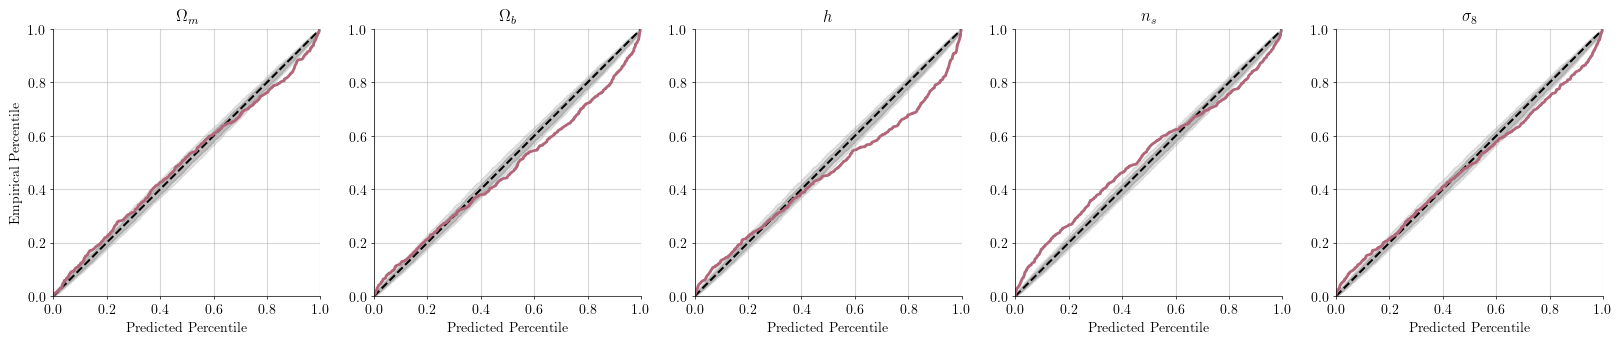

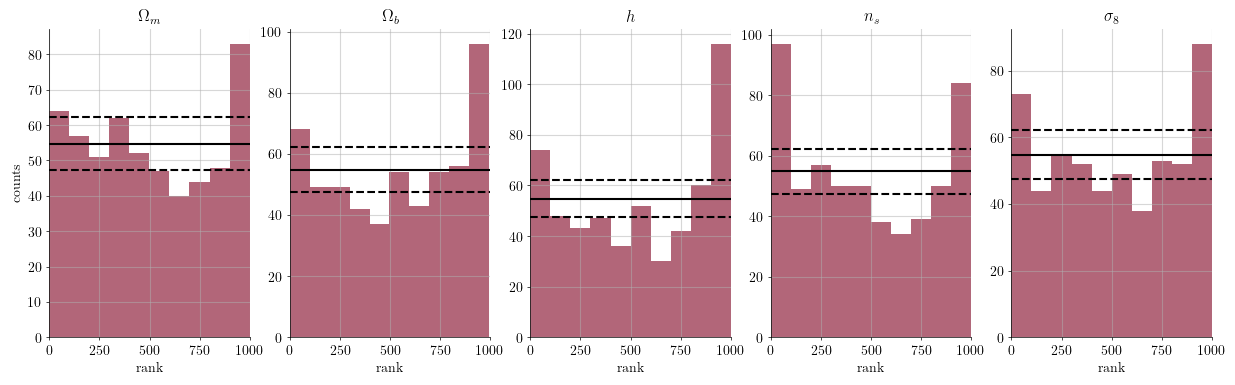

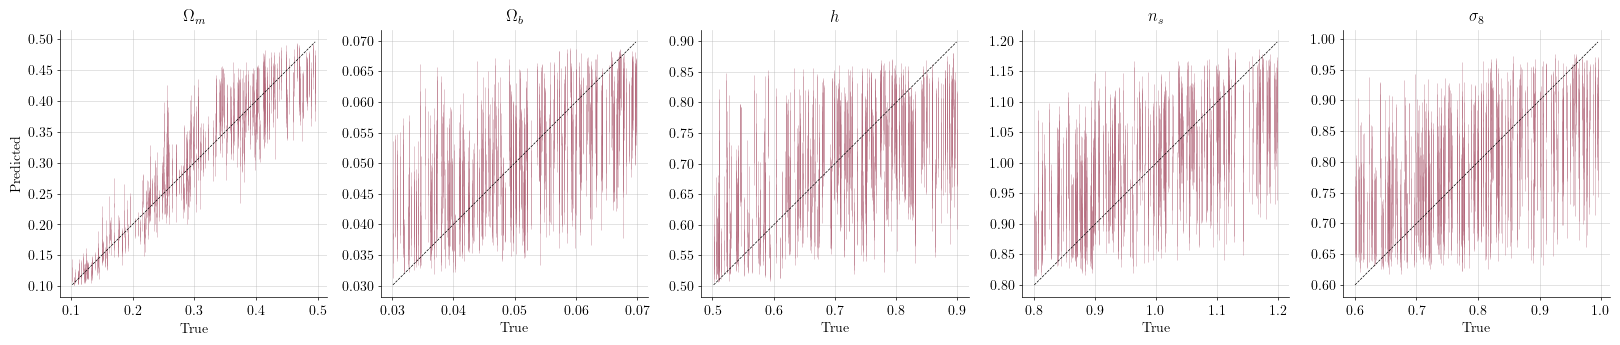

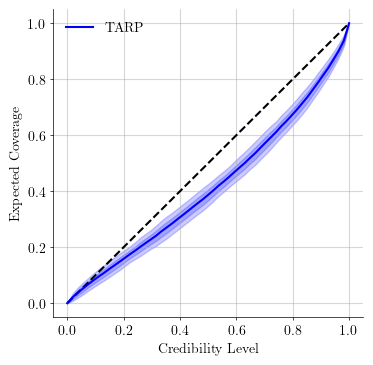

In [162]:
# FOR Pk only

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct',
    labels=labels,
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
) 

skip = 2

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=summz_val[::skip], theta=theta_val[::skip]
)
plt.show()

100%|██████████| 100/100 [00:11<00:00,  9.05it/s]


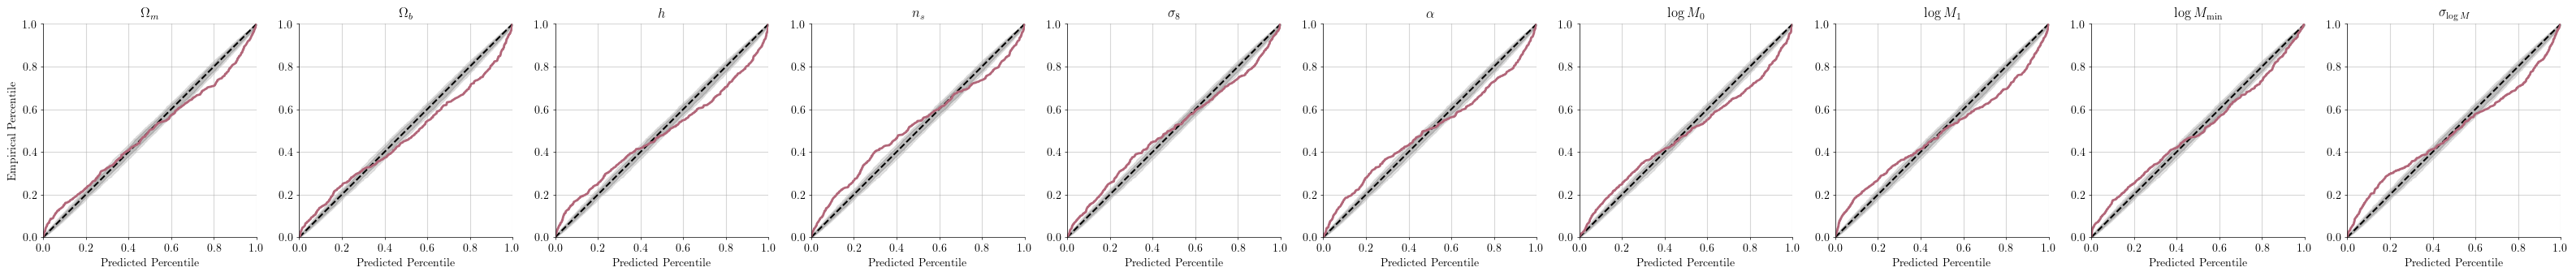

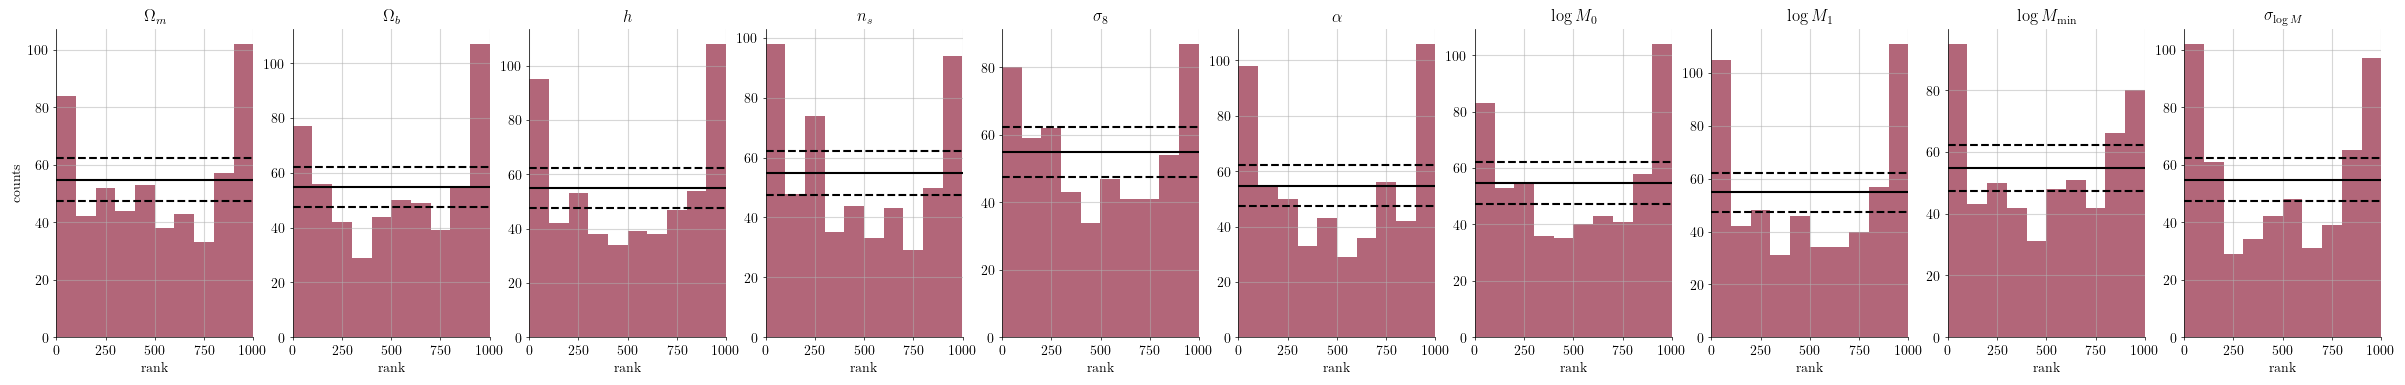

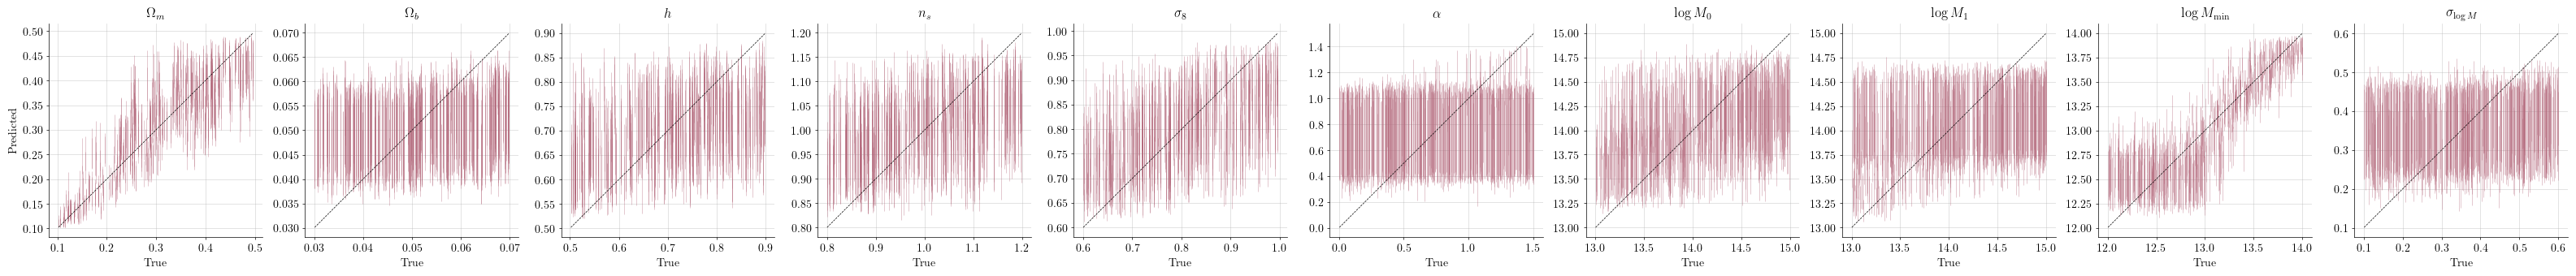

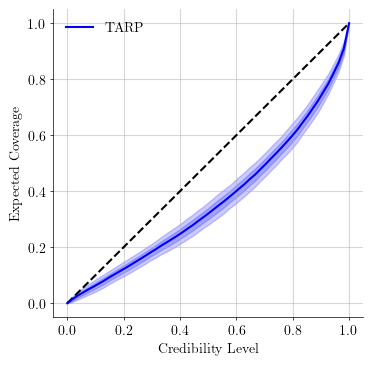

In [82]:
# FOR Pk + Bk

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct',
    labels=labels,
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
) 

skip = 2

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=summz_val[::skip], theta=theta_val[::skip]
)
plt.show()

In [207]:
from ili.embedding import FCN

activation = "SiLU"
n_hidden = [500, 500, 128, 128, 15]
embedding_network = FCN(n_hidden = n_hidden, act_fn = activation)



# do cosmo first
param_idx = [0,1,2,3,4]

#_theta = theta_train[:, param_idx]
_theta = theta_train


print('theta dim', _theta.shape)

loader = NumpyLoader(x=x_train, theta=_theta)

# define a prior for the scaled thetas

prior = ili.utils.Uniform(
    low=_theta.min(axis=0),
    high=_theta.max(axis=0),
    device=device)


# hiddens for NDEs: [16, 64]

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=12),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=12),
]

# define training arguments
train_args = {
    'training_batch_size': 64,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=embedding_network,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

posterior_ensemble_full, summaries_full = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.


theta dim (8786, 10)
 Training neural network. Epochs trained: 46

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 50 47 epochs.

INFO:root:It took 276.1083068847656 seconds to train models.


 Neural network successfully converged after 51 epochs.

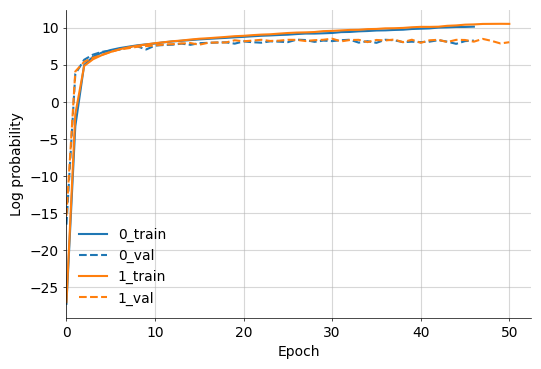

In [210]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries_full):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Drawing 2301 posterior samples:   0%|          | 0/2301 [00:00<?, ?it/s]

Drawing 2699 posterior samples:   0%|          | 0/2699 [00:00<?, ?it/s]

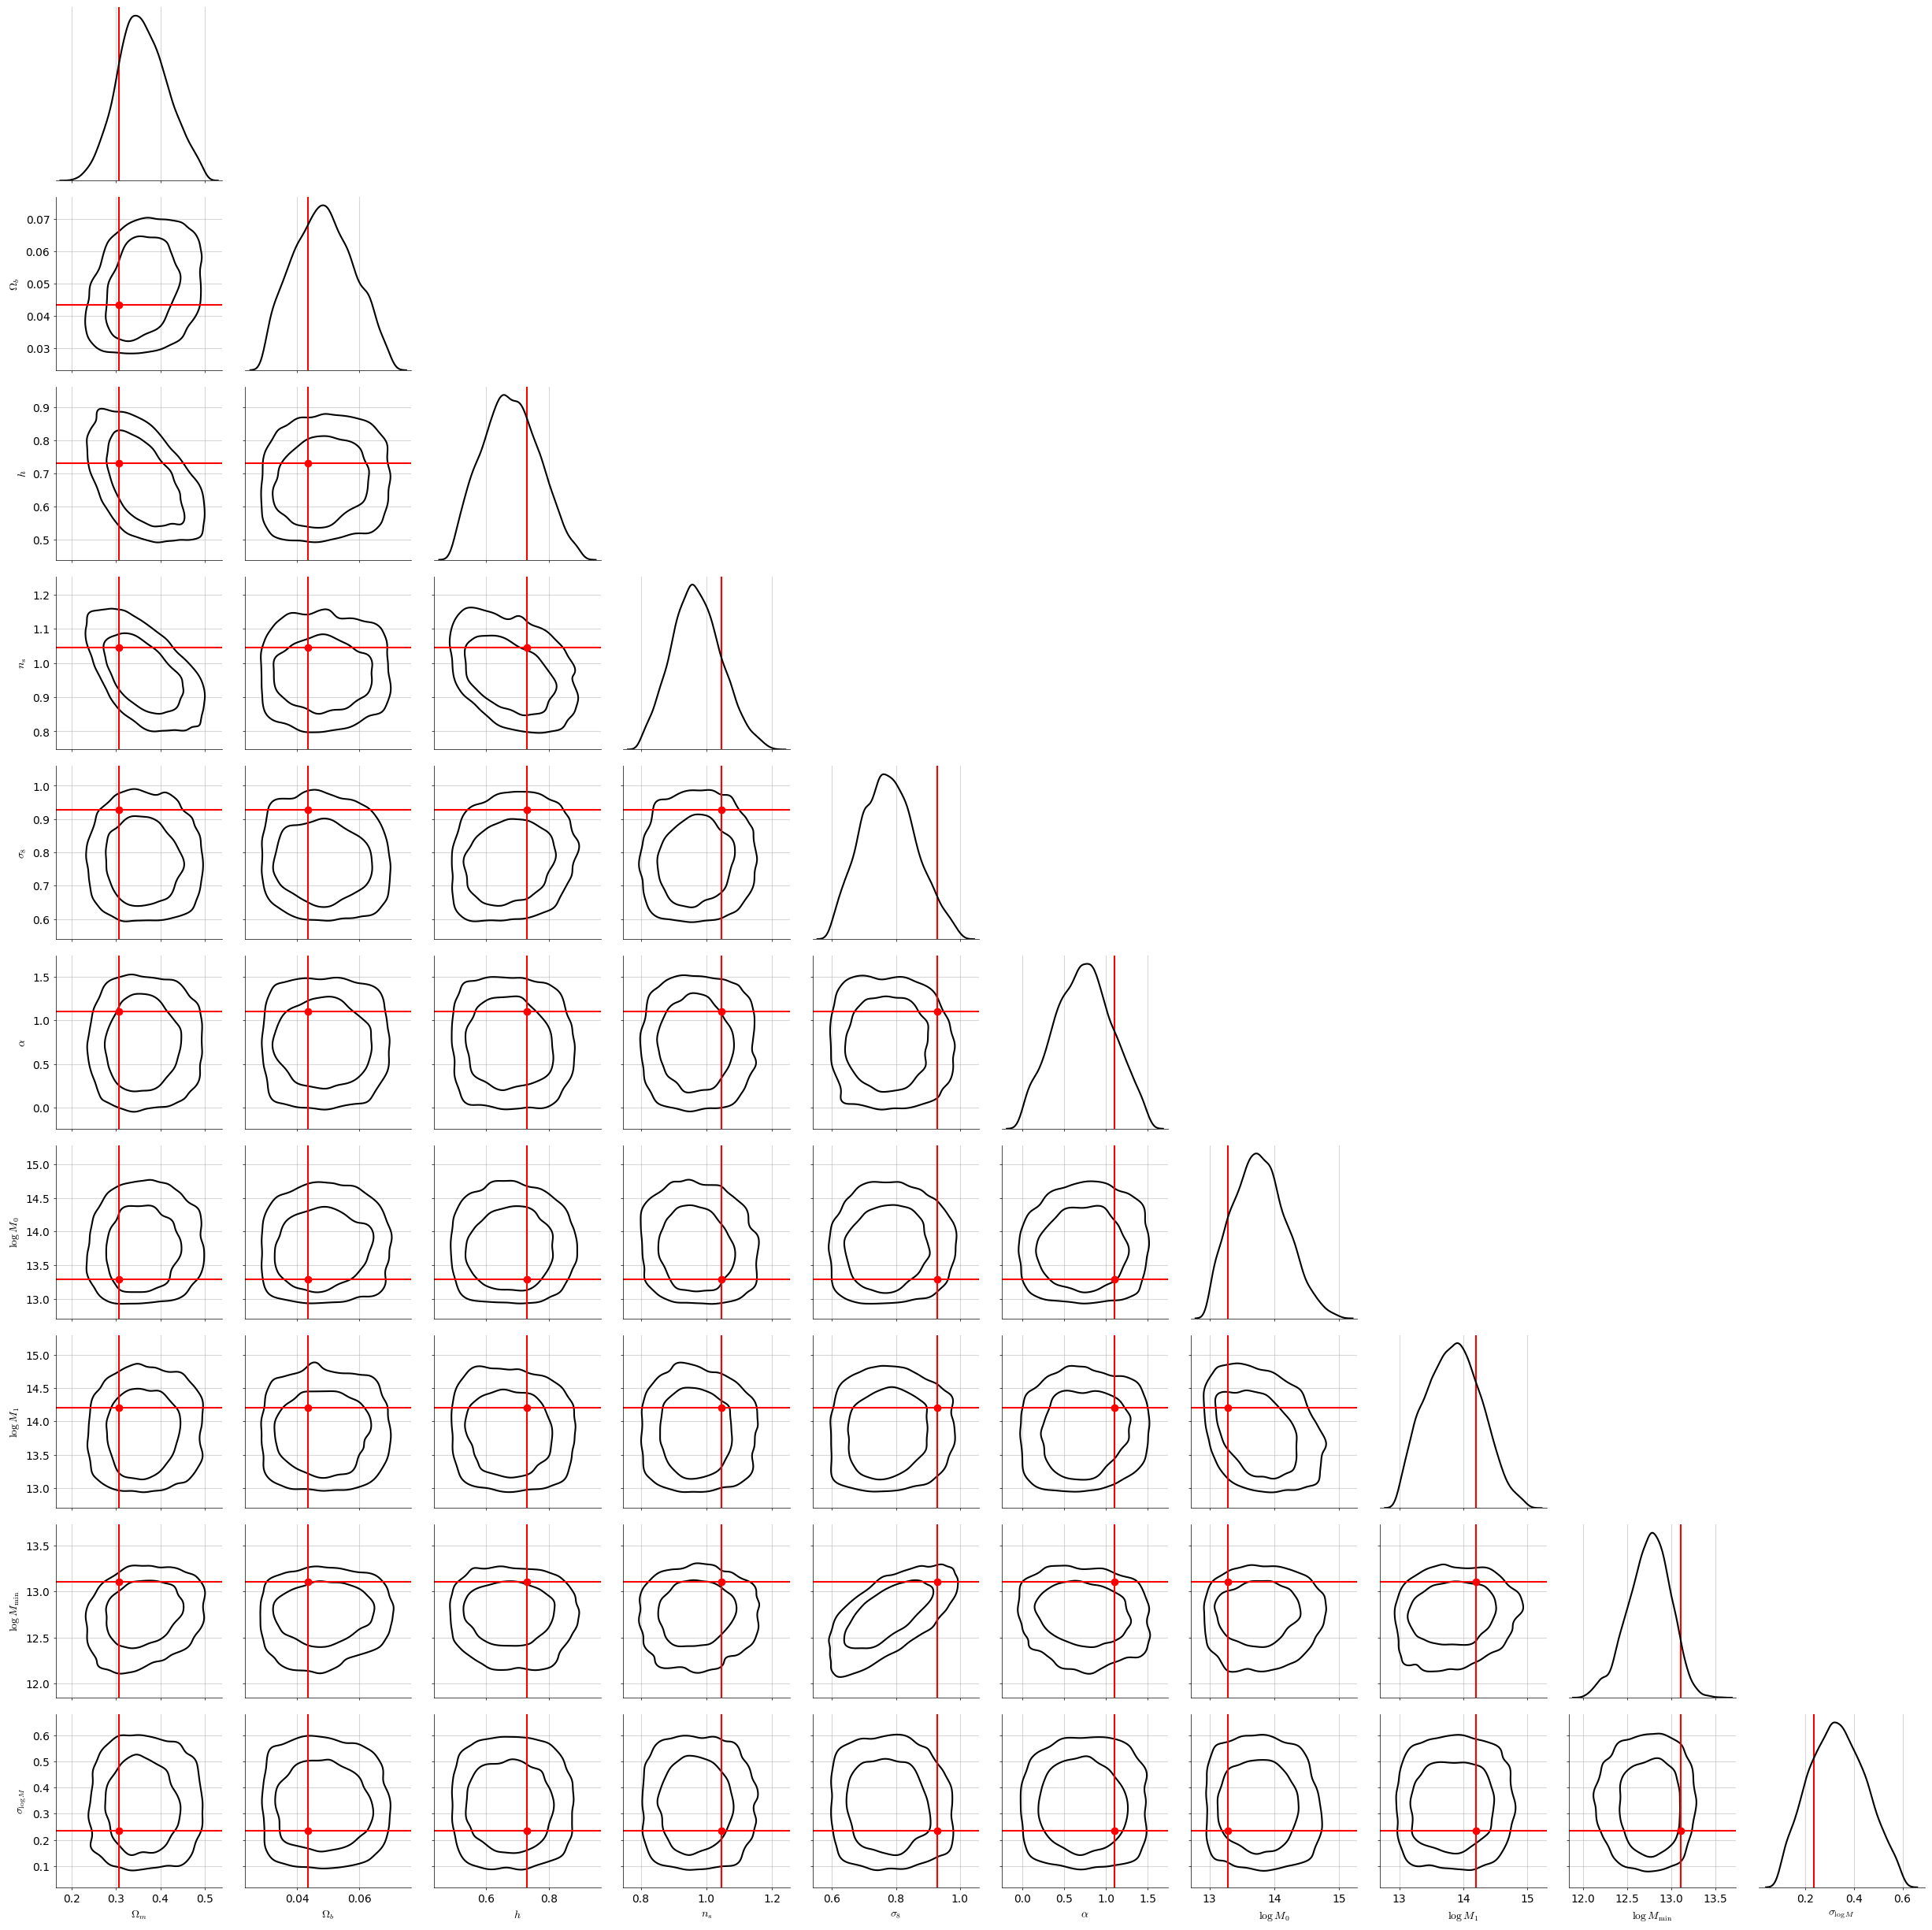

In [216]:
param_idx = [0,1,2,3,4]
#labels = [cosmonames[i] for i in param_idx]
ind = 443

metric = PlotSinglePosterior(
    num_samples=5000, sample_method='direct',
    labels=labels
)
fig = metric(
    posterior=posterior_ensemble_full,
    x_obs = np.array(x_val[ind]), theta_fid=np.array(theta_test[ind])
)

 31%|███▏      | 172/549 [00:37<01:21,  4.60it/s]WARNING:root:Only 0.918% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    361 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 32%|███▏      | 173/549 [00:38<02:04,  3.01it/s]WARNING:root:Only 0.823% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    368 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 39%|███▉      | 214/549 [00:47<01:12,  4.61it/s]WARNING:root:Only 0.029% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    476 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 39%|███▉      | 215/549 [00:52<10:16,  1.8

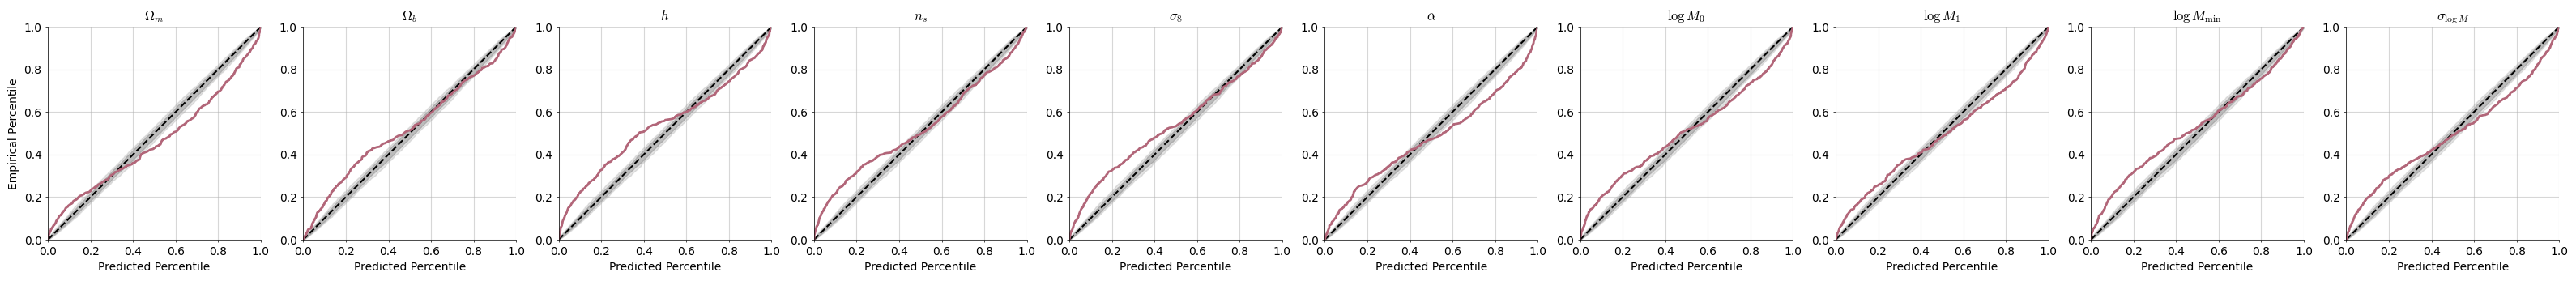

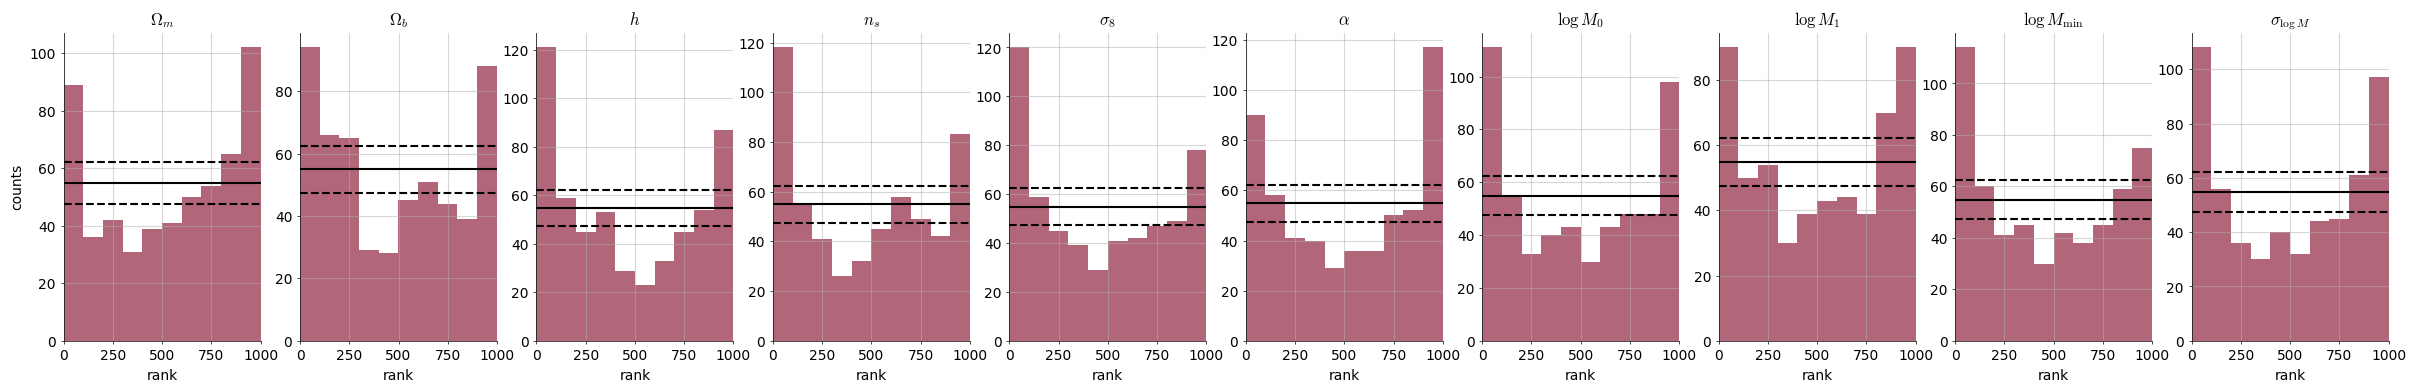

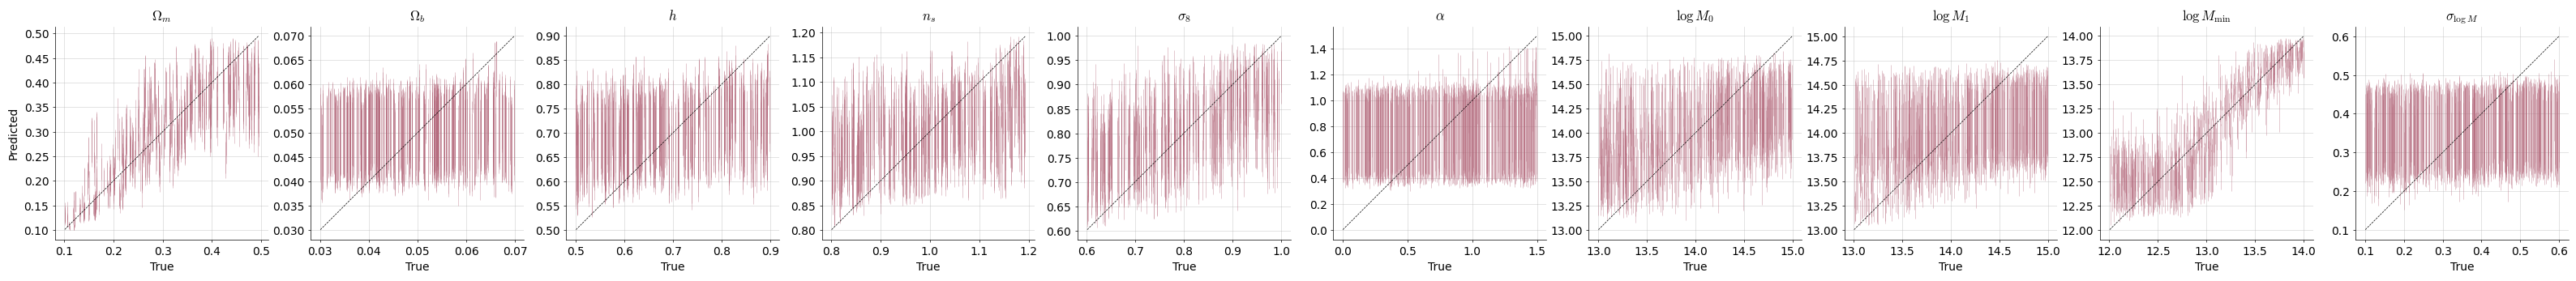

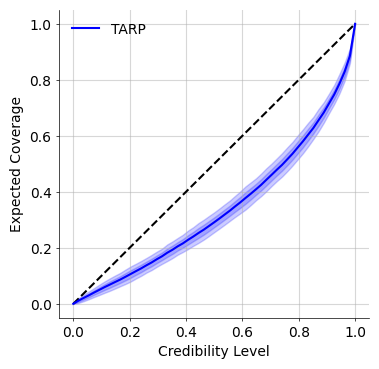

In [222]:
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct',
    labels=labels,
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

skip = 2

fig = metric(
    posterior=posterior_ensemble_full, # NeuralPosteriorEnsemble instance from sbi package
    x=x_test[::skip], theta=theta_test[::skip]
)
plt.show()

In [217]:
ind = 443
chains = posterior_ensemble.sample(x=torch.tensor(summz_test[ind]).to(device), sample_shape=(10000,))

chains_full = posterior_ensemble_full.sample(x=torch.tensor(x_test[ind]).to(device), sample_shape=(10000,))

Drawing 5017 posterior samples:   0%|          | 0/5017 [00:00<?, ?it/s]

Drawing 4983 posterior samples:   0%|          | 0/4983 [00:00<?, ?it/s]

Drawing 4656 posterior samples:   0%|          | 0/4656 [00:00<?, ?it/s]

Drawing 5344 posterior samples:   0%|          | 0/5344 [00:00<?, ?it/s]

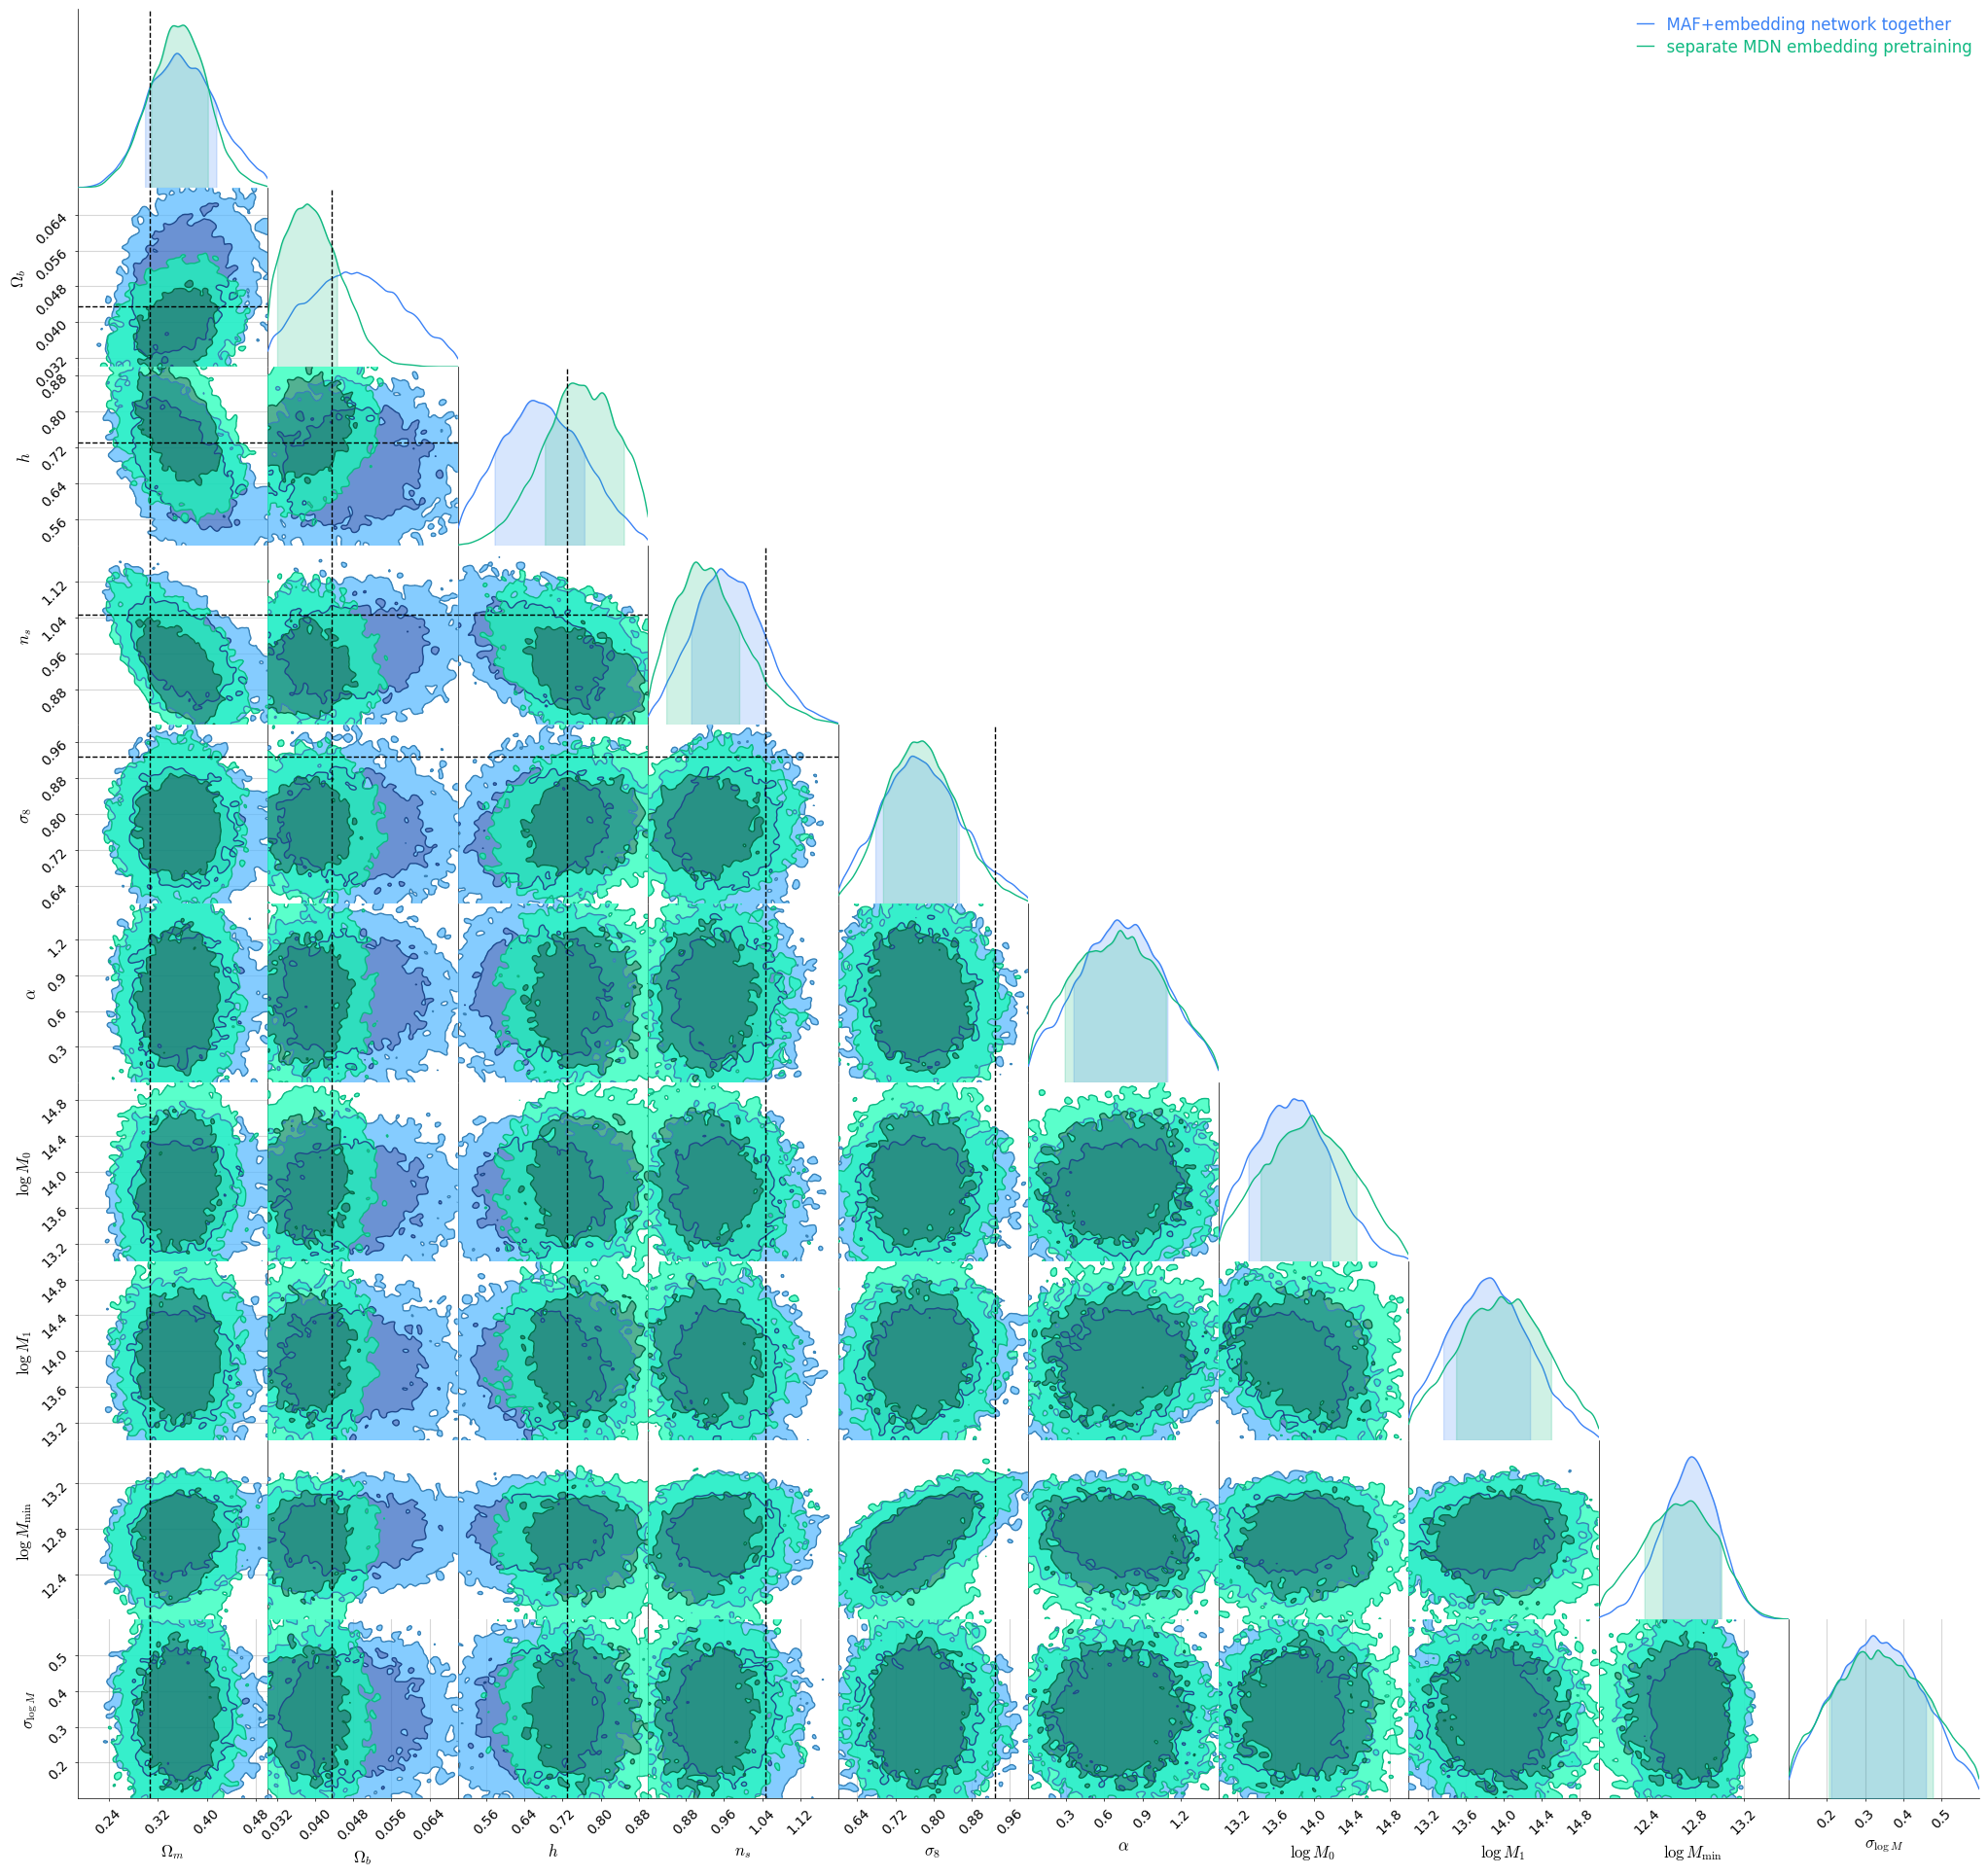

In [221]:
# MAF
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd




#simbig_df = pd.DataFrame(pd.read_csv("simbig_pk.csv").values, columns=cosmonames[param_idx])

df024 = pd.DataFrame(chains.cpu().numpy(), columns=labels)
df02 = pd.DataFrame(chains_full.cpu().numpy(), columns=labels)

c = ChainConsumer()

#c.add_chain(Chain(samples=simbig_df, name=r"simBig",))

c.add_chain(Chain(samples=df02, name="MAF+embedding network together",))
c.add_chain(Chain(samples=df024, name="separate MDN embedding pretraining",))

target_theta = theta_test[ind]
c.add_truth(Truth(location={
                            cosmonames[0]: target_theta[0], 
                            cosmonames[1]: target_theta[1], 
                            cosmonames[2]: target_theta[2],
                            cosmonames[3]: target_theta[3], 
                            cosmonames[4]: target_theta[4],


                            
                           }))

fig = c.plotter.plot()
plt.show()


In [39]:
# run inference as a function of multipole

from ili.embedding import FCN


def run_inference(folder):

    print('running inference for', folder)
    
    x_train = np.load(folder + "x_train.npy")
    theta_train = np.load(folder + "theta_train.npy")
    
    x_test = np.load(folder + "x_test.npy")
    theta_test = np.load(folder + "theta_test.npy")
    
    print(x_train.shape, theta_train.shape, x_test.shape, theta_test.shape)
    
    activation = "SiLU"
    n_hidden = [128, 128, 3]
    embedding_network = FCN(n_hidden = n_hidden, act_fn = activation)
    
    
    
    # do sigma8 first
    param_idx = [4]
    
    _theta = theta_train[:, param_idx]
    
    print('theta dim', _theta.shape)
    
    loader = NumpyLoader(x=x_train, theta=_theta)
    
    # define a prior for the scaled thetas
    
    prior = ili.utils.Uniform(
        low=_theta.min(axis=0),
        high=_theta.max(axis=0),
        device=device)
    
    
    # hiddens for NDEs: [16, 64]
    
    # instantiate your neural networks to be used as an ensemble
    nets = [
        ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=30, num_transforms=5),
        ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=40, num_transforms=6),
    ]
    
    # define training arguments
    train_args = {
        'training_batch_size': 64,
        'learning_rate': 1e-4
    }
    
    # initialize the trainer
    runner = InferenceRunner.load(
        backend='sbi',
        engine='NPE',
        prior=prior,
        nets=nets,
        device=device,
        embedding_net=embedding_network,
        train_args=train_args,
        proposal=None,
        out_dir=None
    )
    
    posterior_ensemble, summaries = runner(loader=loader)

    return posterior_ensemble, summaries, theta_train, x_train, theta_test, x_test

In [40]:
posterior_ensemble_pk02, summaries, theta_train_pk02, x_train_pk02, theta_test_pk02, x_test_pk02 = run_inference(folder)

running inference for /data101/makinen/pk_cmass/sigma8_comparison/Pk0+Pk2/kmax-0.4/
(8478, 444) (8478, 10) (950, 444) (950, 10)
theta dim (8478, 1)


INFO:root:MODEL INFERENCE CLASS: NPE
/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 2.
/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/neural_nets/flow.py:142: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Training neural network. Epochs trained: 43

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 2 / 2.


 Neural network successfully converged after 44 epochs.

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/neural_nets/flow.py:142: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Training neural network. Epochs trained: 44

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 123.79719972610474 seconds to train models.


 Neural network successfully converged after 45 epochs.

Drawing 2480 posterior samples:   0%|          | 0/2480 [00:00<?, ?it/s]

Drawing 2520 posterior samples:   0%|          | 0/2520 [00:00<?, ?it/s]

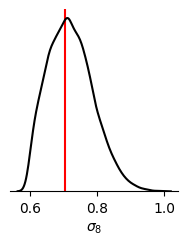

In [46]:
param_idx = [4]
labels = [cosmonames[i] for i in param_idx]
ind = 443

metric = PlotSinglePosterior(
    num_samples=5000, sample_method='direct',
    labels=labels
)
fig = metric(
    posterior=posterior_ensemble_pk02,
    x_obs = np.array(x_test_pk02[ind]), theta_fid=np.array(theta_test[ind, param_idx])
)

In [43]:
folder2 = "/data101/makinen/pk_cmass/sigma8_comparison/Pk0+Pk2+Pk4/kmax-0.4/"
posterior_ensemble_pk024, summaries_pk024, theta_train_pk024, x_train_pk024, theta_test_pk024, x_test_pk024 = run_inference(folder2)

INFO:root:MODEL INFERENCE CLASS: NPE
/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 2.


running inference for /data101/makinen/pk_cmass/sigma8_comparison/Pk0+Pk2+Pk4/kmax-0.4/
(8478, 666) (8478, 10) (950, 666) (950, 10)
theta dim (8478, 1)


/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/neural_nets/flow.py:142: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Training neural network. Epochs trained: 32

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 32 33 epochs.

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 84.89793133735657 seconds to train models.


 Neural network successfully converged after 33 epochs.

Drawing 2537 posterior samples:   0%|          | 0/2537 [00:00<?, ?it/s]

Drawing 2463 posterior samples:   0%|          | 0/2463 [00:00<?, ?it/s]

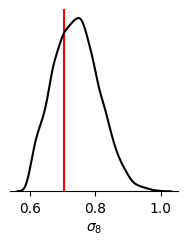

In [45]:
param_idx = [4]
labels = [cosmonames[i] for i in param_idx]
ind = 443

metric = PlotSinglePosterior(
    num_samples=5000, sample_method='direct',
    labels=labels
)
fig = metric(
    posterior=posterior_ensemble_pk024,
    x_obs = np.array(x_test_pk024[ind]), theta_fid=np.array(theta_test[ind, param_idx])
)

In [48]:
# theta_fid = np.array([0.3, 0.05, 0.7, 1.0, 0.8] + list(theta_test)
ind_fid = np.argmin(np.mean((theta_test.mean(0) - theta_test)**2))

target_theta = theta_test[ind_fid]



chain_02 = posterior_ensemble_pk02.sample((10000,), torch.Tensor(x_test_pk02[ind_fid]).to(device)).cpu().numpy()

chain_024 = posterior_ensemble_pk024.sample((10000,), torch.Tensor(x_test_pk024[ind_fid]).to(device)).cpu().numpy()

Drawing 4935 posterior samples:   0%|          | 0/4935 [00:00<?, ?it/s]

Drawing 5065 posterior samples:   0%|          | 0/5065 [00:00<?, ?it/s]

Drawing 4979 posterior samples:   0%|          | 0/4979 [00:00<?, ?it/s]

Drawing 5021 posterior samples:   0%|          | 0/5021 [00:00<?, ?it/s]

In [50]:
param_idx

[4]

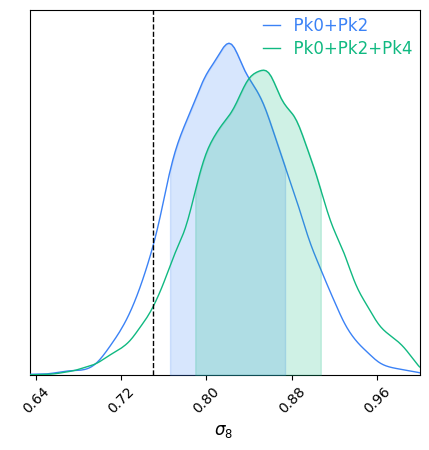

In [52]:
# MAF
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd




#simbig_df = pd.DataFrame(pd.read_csv("simbig_pk.csv").values, columns=cosmonames[param_idx])

df024 = pd.DataFrame(chain_024, columns=[cosmonames[4]])
df02 = pd.DataFrame(chain_02, columns=[cosmonames[4]])

c = ChainConsumer()

#c.add_chain(Chain(samples=simbig_df, name=r"simBig",))


c.add_chain(Chain(samples=df02, name="Pk0+Pk2",))
c.add_chain(Chain(samples=df024, name="Pk0+Pk2+Pk4",))


c.add_truth(Truth(location={
                            # cosmonames[0]: target_theta[0], 
                            # cosmonames[1]: target_theta[1], 
                            # cosmonames[2]: target_theta[2],
                            # cosmonames[3]: target_theta[3], 
                            cosmonames[4]: target_theta[4],
                           }))

fig = c.plotter.plot()
plt.show()
